In [ ]:
%%capture
!pip install opendatasets

# Libraries

In [ ]:
import os
import opendatasets as od
from pathlib import Path
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance
import skimage.color
import cv2
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from IPython.display import HTML
import base64
import keras
import operator
import time
from sklearn.utils import resample
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Activation, DepthwiseConv2D, GlobalAveragePooling2D, Add, ZeroPadding2D,AveragePooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC, SpecificityAtSensitivity
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Useful functions for all the datasets and models

In [ ]:
def plot_pie_chart(df, column_name, title, figsize=(4, 4), colors=None):
    if colors is None:
        colors = ['#FFD1DC', '#C4E3F3', '#B2FBA5', '#FFFACD']

    label_counts = df[column_name].value_counts()

    def format_label(pct, all_vals):
        absolute = int(round(pct / 100. * sum(all_vals)))
        return f"{pct:.1f}%\n({absolute})"

    plt.figure(figsize=figsize)
    plt.pie(
        label_counts,
        labels=label_counts.index,
        autopct=lambda pct: format_label(pct, label_counts),
        startangle=140,
        colors=colors
    )
    plt.title(title + '\n')
    plt.axis('equal')
    plt.show()

In [ ]:
def create_shuffled_dataframe(dataset_dir):
    # Initialize lists to store file paths and labels
    filepaths = []
    labels = []

    # Iterate over class directories in the dataset
    for class_folder in dataset_dir.iterdir():
        if class_folder.is_dir():
            class_name = class_folder.name  # Class label from folder name
            for img_path in class_folder.glob("*.*"):  # Collect all image files
                filepaths.append(str(img_path))
                labels.append(class_name)

    # Create a DataFrame
    dataframe = pd.DataFrame({
        "Filepath": filepaths,
        "Label": labels
    })

    # Shuffle the DataFrame
    dataframe = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

    return dataframe

In [ ]:
def plot_sample_images(df, num_images=5):

    plt.figure(figsize=(15, 5))
    sampled_df = df.sample(n=num_images, random_state=42)

    for idx, row in enumerate(sampled_df.iterrows()):
        img_path = row[1]['Filepath']
        label = row[1]['Label']

        # Read the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Plot the image
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(model, test_gen, class_names=None):

    # Evaluate the model on the test data
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_gen)

    # Print evaluation results
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test AUC: {test_auc}")

    # Predict class probabilities
    y_pred_probs = model.predict(test_gen)

    # Get predicted class indices
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Get true class indices
    y_true = test_gen.classes

    # If class names are not provided, extract them from the generator
    if class_names is None:
        class_names = list(test_gen.class_indices.keys())

    # Generate and print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Generate Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Return metrics as a dictionary
    metrics = {
        "Test Loss": test_loss,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test AUC": test_auc
    }

    return metrics

In [ ]:
def save_training_history(history, file_name):

    # Convert the history.history dict to a pandas DataFrame
    hist_df = pd.DataFrame(history.history)

    # Save history to CSV
    with open(file_name, mode='w') as f:
        hist_df.to_csv(f)

    print(f"Training history saved to {file_name} successfully.")

# Datasets

## Original dataset

In [ ]:
# Kaggle URL for the dataset
dataset_kaggle_url = "https://www.kaggle.com/tawsifurrahman/covid19-radiography-database"

# Download the dataset
od.download(dataset_kaggle_url)
dataset_folder_path = "covid19-radiography-database/COVID-19_Radiography_Dataset"

print(os.listdir(dataset_folder_path))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: LRMRTN
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:03<00:00, 253MB/s]



['Lung_Opacity.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'Lung_Opacity', 'README.md.txt', 'Normal.metadata.xlsx', 'COVID', 'COVID.metadata.xlsx', 'Normal']


In [ ]:
original_dataset_dir = Path(r"covid19-radiography-database/COVID-19_Radiography_Dataset")

filepaths = list(original_dataset_dir.glob('*/images/*.*'))
labels = [os.path.basename(os.path.dirname(filepath.parent)) for filepath in filepaths]
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatinate
df = pd.concat([filepaths, labels], axis=1)

# Check
print(df.sample(n=5, random_state=42))

                                                Filepath         Label
21113  covid19-radiography-database/COVID-19_Radiogra...        Normal
10611  covid19-radiography-database/COVID-19_Radiogra...         COVID
2127   covid19-radiography-database/COVID-19_Radiogra...  Lung_Opacity
14366  covid19-radiography-database/COVID-19_Radiogra...        Normal
12463  covid19-radiography-database/COVID-19_Radiogra...        Normal


In [ ]:
# Check for null values
null_values = df.isnull().sum()
print("Null values in the dataset:")
print(null_values)
len(df)

Null values in the dataset:
Filepath    0
Label       0
dtype: int64


21165

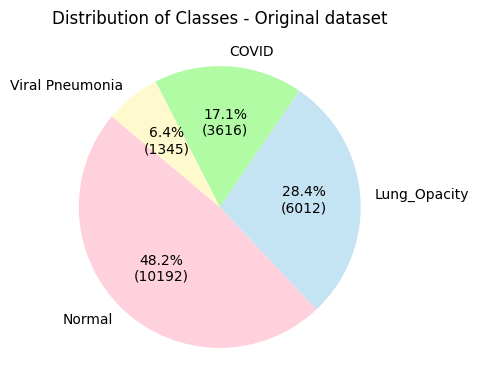

In [ ]:
plot_pie_chart(df, 'Label', 'Distribution of Classes - Original dataset')

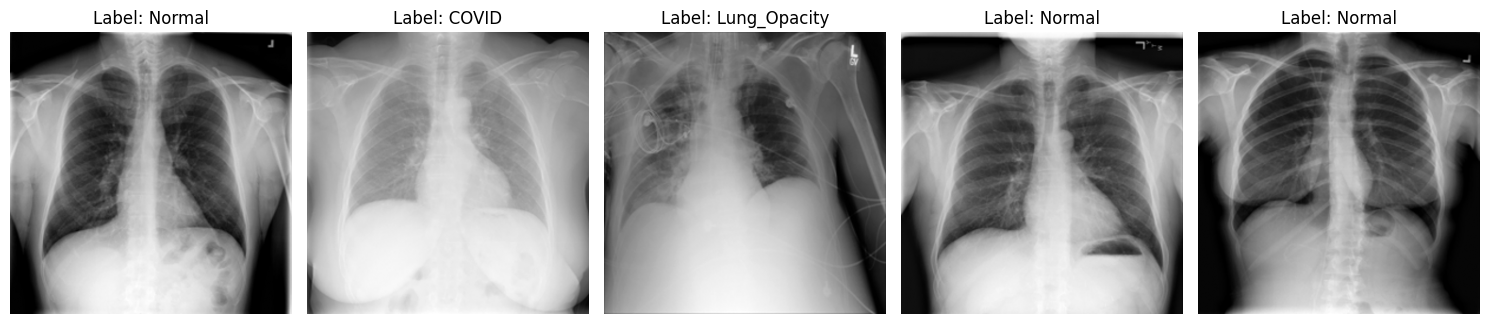

In [ ]:
plot_sample_images(df, num_images=5)

## Balanced dataset

In [ ]:
# Define the original dataset directory
original_dataset_dir = Path(r"covid19-radiography-database/COVID-19_Radiography_Dataset")

# Get file paths and labels
filepaths = list(original_dataset_dir.glob('*/images/*.*'))
labels = [os.path.basename(os.path.dirname(filepath.parent)) for filepath in filepaths]

# Create DataFrame
df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
df['Filepath'] = df['Filepath'].astype(str)  # Convert to string for compatibility

# Undersampling: Keep 1,345 images per class
df_balanced = df.groupby("Label").apply(lambda x: x.sample(n=1345, random_state=42)).reset_index(drop=True)

# Check the new dataset
print(df_balanced.sample(n=5, random_state=42))

                                               Filepath            Label
705   covid19-radiography-database/COVID-19_Radiogra...            COVID
4788  covid19-radiography-database/COVID-19_Radiogra...  Viral Pneumonia
1212  covid19-radiography-database/COVID-19_Radiogra...            COVID
1379  covid19-radiography-database/COVID-19_Radiogra...     Lung_Opacity
5370  covid19-radiography-database/COVID-19_Radiogra...  Viral Pneumonia


<ipython-input-13-ef34c1a7dcb8>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("Label").apply(lambda x: x.sample(n=1345, random_state=42)).reset_index(drop=True)


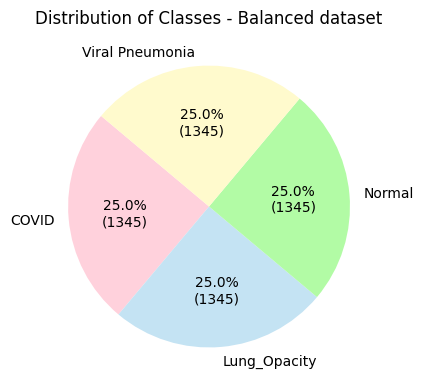

In [ ]:
plot_pie_chart(df_balanced, 'Label', 'Distribution of Classes - Balanced dataset')

## Original + masks

In [ ]:
# Define the dataset directory
original_dataset_dir = Path(r"covid19-radiography-database/COVID-19_Radiography_Dataset")

# Create a directory to save masked images in Google Colab
masked_images_dir = Path("original_masked")
masked_images_dir.mkdir(exist_ok=True)

# Get all image and mask file paths
image_filepaths = list(original_dataset_dir.glob('*/images/*.*'))
mask_filepaths = list(original_dataset_dir.glob('*/masks/*.*'))

# Convert to Pandas DataFrame
image_df = pd.DataFrame({'Filepath': image_filepaths})
mask_df = pd.DataFrame({'Mask_Filepath': mask_filepaths})

# Convert paths to string format
image_df['Filepath'] = image_df['Filepath'].astype(str)
mask_df['Mask_Filepath'] = mask_df['Mask_Filepath'].astype(str)

# Extract labels based on folder names (COVID, Viral Pneumonia, Lung_Opacity, Normal)
image_df['Label'] = image_df['Filepath'].apply(lambda x: Path(x).parents[1].name)
mask_df['Label'] = mask_df['Mask_Filepath'].apply(lambda x: Path(x).parents[1].name)

# Extract filenames without extensions to use as unique keys for merging
image_df['Filename'] = image_df['Filepath'].apply(lambda x: Path(x).stem)
mask_df['Filename'] = mask_df['Mask_Filepath'].apply(lambda x: Path(x).stem)

# Merge images and masks using the filename to ensure one-to-one mapping
df = image_df.merge(mask_df, on='Filename')

# Drop redundant columns
df.drop(columns=['Filename', 'Label_y'], inplace=True)

# Rename the remaining label column
df.rename(columns={'Label_x': 'Label'}, inplace=True)

# Function to apply mask to image and save it
def apply_mask_and_save(img_path, mask_path, save_path, target_size=(299, 299)):
    # Load image and mask
    img = load_img(img_path, target_size=target_size)
    mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')

    # Convert to arrays
    img_array = img_to_array(img)
    mask_array = img_to_array(mask)

    # Ensure the mask is binary (0 for background, 1 for lung region)
    mask_array = np.where(mask_array > 127, 1, 0).astype(np.uint8)

    # Apply the mask to the image (multiply them)
    masked_image = img_array * mask_array

    # Convert back to image and save
    masked_img = array_to_img(masked_image)
    masked_img.save(save_path)

# Create a new dataframe with masked image file paths
masked_image_records = []

# Loop through the dataframe to apply masks and save new images
for _, row in df.iterrows():
    img_path = row['Filepath']
    mask_path = row['Mask_Filepath']

    # Define save path
    masked_img_filename = Path(img_path).name  # Keep the original filename
    save_path = masked_images_dir / masked_img_filename

    # Apply mask and save image
    apply_mask_and_save(img_path, mask_path, save_path)

    # Append file path and label to the new dataframe
    masked_image_records.append({
        'Masked_Filepath': str(save_path),
        'Label': row['Label']
    })

# Create a new dataframe for masked images
original_masked_df = pd.DataFrame(masked_image_records)

In [ ]:
# Rename the 'Mask_Filepath' column to 'Filepath'
original_masked_df.rename(columns={'Masked_Filepath': 'Filepath'}, inplace=True)

print(original_masked_df.sample(n=5, random_state=42))

                                    Filepath         Label
21113        original_masked/Normal-5773.png        Normal
10611         original_masked/COVID-2246.png         COVID
2127   original_masked/Lung_Opacity-2362.png  Lung_Opacity
14366        original_masked/Normal-5342.png        Normal
12463        original_masked/Normal-7420.png        Normal


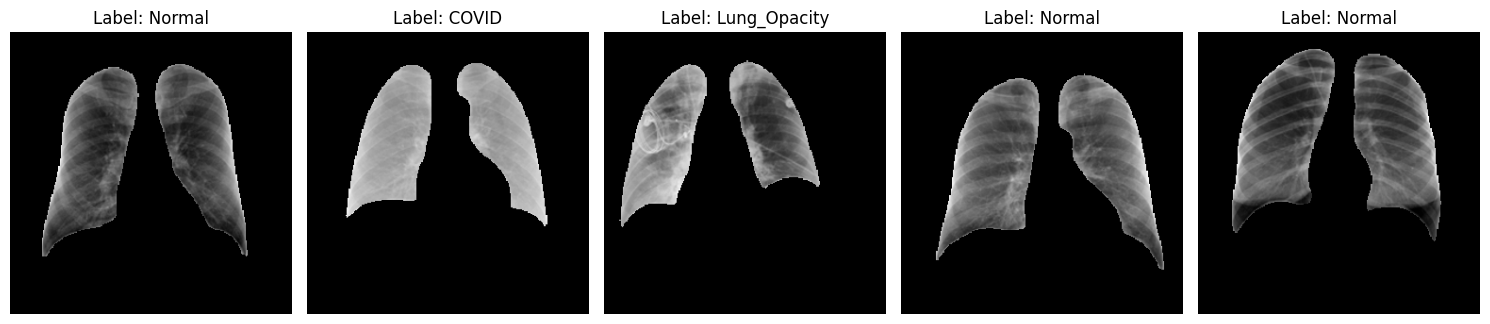

In [ ]:
plot_sample_images(original_masked_df, num_images=5)

## Original + CLAHE

In [ ]:
def apply_clahe_to_images(df, save_folder, clip_limit=2.0, tile_grid_size=(8, 8), extension='png'):

    save_folder = Path(save_folder)
    save_folder.mkdir(parents=True, exist_ok=True)

    for i in range(len(df)):
        img_path = df['Filepath'].iloc[i]
        label = df['Label'].iloc[i]

        # Read image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        img_clahe = clahe.apply(img)

        # Create label subdirectory if it doesn't exist
        label_dir = save_folder / label
        label_dir.mkdir(parents=True, exist_ok=True)

        # Save processed image
        file_name = Path(img_path).stem  # Extract original file name
        save_path = label_dir / f"{file_name}_clahe.{extension}"
        cv2.imwrite(str(save_path), img_clahe)

In [ ]:
# Specify output directory for CLAHE-processed images
original_CLAHE_dir = Path("/content/original_CLAHE")

# Apply CLAHE to all images in the dataframe
apply_clahe_to_images(df, original_CLAHE_dir, clip_limit=2.0, tile_grid_size=(8, 8), extension='png')

print("CLAHE processing completed. Processed images saved to:", original_CLAHE_dir)

CLAHE processing completed. Processed images saved to: /content/original_CLAHE


In [ ]:
# Create dataframe for original dataset
original_CLAHE_df = create_shuffled_dataframe(original_CLAHE_dir)
print(original_CLAHE_df.head())

                                            Filepath            Label
0  /content/original_CLAHE/Lung_Opacity/Lung_Opac...     Lung_Opacity
1  /content/original_CLAHE/COVID/COVID-1724_clahe...            COVID
2  /content/original_CLAHE/Normal/Normal-8195_cla...           Normal
3  /content/original_CLAHE/Viral Pneumonia/Viral ...  Viral Pneumonia
4  /content/original_CLAHE/COVID/COVID-1929_clahe...            COVID


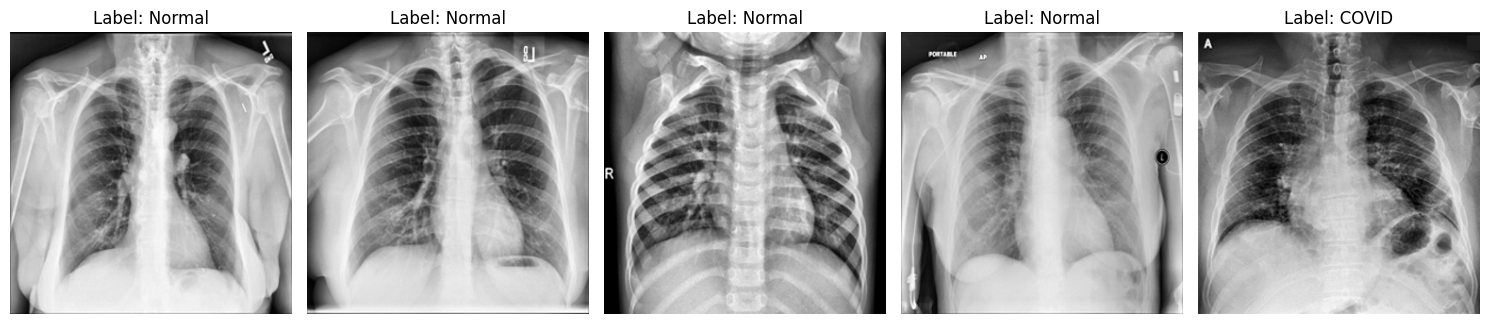

In [ ]:
plot_sample_images(original_CLAHE_df, num_images=5)

## Original + Image Complement

In [ ]:
def apply_complement_to_images(df, save_folder, extension='png'):

    save_folder = Path(save_folder)
    save_folder.mkdir(parents=True, exist_ok=True)

    for i in range(len(df)):
        img_path = df['Filepath'].iloc[i]
        label = df['Label'].iloc[i]

        # Read image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Apply image complement (invert pixel values)
        img_complement = 255 - img

        # Create label subdirectory if it doesn't exist
        label_dir = save_folder / label
        label_dir.mkdir(parents=True, exist_ok=True)

        # Save processed image
        file_name = Path(img_path).stem  # Extract original file name
        save_path = label_dir / f"{file_name}_complement.{extension}"
        cv2.imwrite(str(save_path), img_complement)

In [ ]:
# Specify output directory for Complement-processed images
original_complement_dir = Path("/content/original_complement")

# Apply Complement to all images in the dataframe
apply_complement_to_images(df, original_complement_dir, extension='png')

print("Complement processing completed. Processed images saved to:", original_complement_dir)

Complement processing completed. Processed images saved to: /content/original_complement


In [ ]:
# Create dataframe for original dataset
original_complement_df = create_shuffled_dataframe(original_complement_dir)
print(original_complement_df.head())

                                            Filepath            Label
0  /content/original_complement/Lung_Opacity/Lung...     Lung_Opacity
1  /content/original_complement/COVID/COVID-3314_...            COVID
2  /content/original_complement/Normal/Normal-266...           Normal
3  /content/original_complement/Viral Pneumonia/V...  Viral Pneumonia
4  /content/original_complement/COVID/COVID-166_c...            COVID


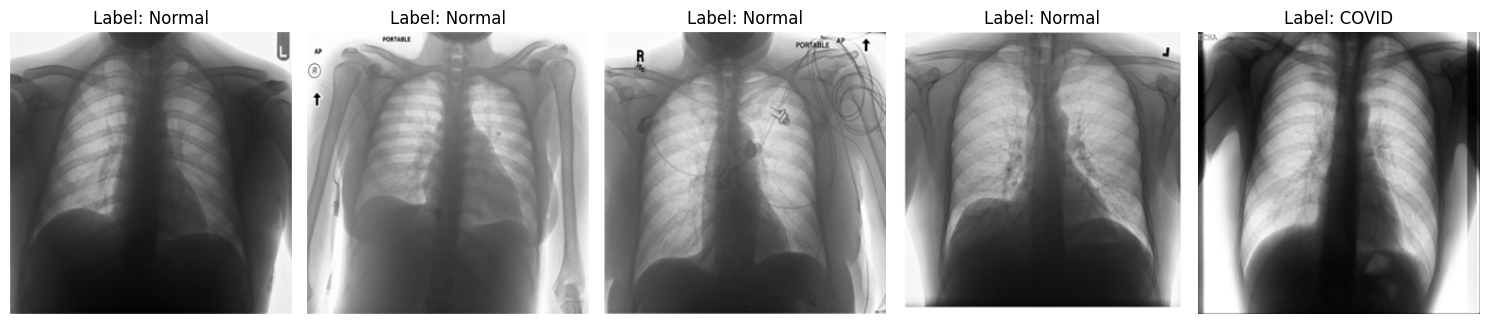

In [ ]:
plot_sample_images(original_complement_df, num_images=5)

## Original + Canny

In [ ]:
def apply_canny_to_images(df, save_folder, extension='png', threshold1=50, threshold2=200):

    save_folder = Path(save_folder)
    save_folder.mkdir(parents=True, exist_ok=True)

    for i in range(len(df)):
        img_path = df['Filepath'].iloc[i]
        label = df['Label'].iloc[i]

        # Read image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to read image at {img_path}")
            continue

        # Apply Canny edge detection
        img_canny = cv2.Canny(img, threshold1, threshold2)

        # Create label subdirectory if it doesn't exist
        label_dir = save_folder / label
        label_dir.mkdir(parents=True, exist_ok=True)

        # Save processed image
        file_name = Path(img_path).stem  # Extract original file name
        save_path = label_dir / f"{file_name}_canny.{extension}"
        cv2.imwrite(str(save_path), img_canny)

In [ ]:
# Specify output directory for Canny-processed images
original_canny_dataset_dir = Path("/content/original_canny")

# Apply Cannyto all images in the dataframe
apply_canny_to_images(df, original_canny_dataset_dir, extension='png', threshold1=30, threshold2=60)

print("Canny processing completed. Processed images saved to:", original_canny_dataset_dir)

Canny processing completed. Processed images saved to: /content/original_canny


In [ ]:
# Create dataframe for the Canny-processed dataset
original_canny_df = create_shuffled_dataframe(original_canny_dataset_dir)
print(original_canny_df.head())

                                            Filepath            Label
0  /content/original_canny/Lung_Opacity/Lung_Opac...     Lung_Opacity
1  /content/original_canny/COVID/COVID-1135_canny...            COVID
2  /content/original_canny/Normal/Normal-6335_can...           Normal
3  /content/original_canny/Viral Pneumonia/Viral ...  Viral Pneumonia
4  /content/original_canny/COVID/COVID-1974_canny...            COVID


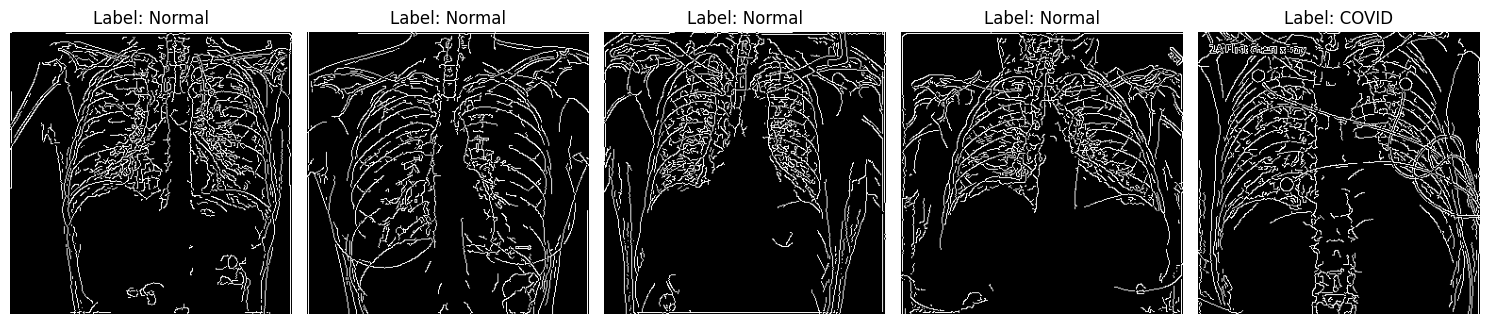

In [ ]:
plot_sample_images(original_canny_df, num_images=5)

## Binary

In [ ]:
# Create binary labels: "COVID" vs "non-COVID"
binary_labels = df['Label'].apply(lambda x: 'COVID' if x == 'COVID' else 'non-COVID')

# Create the new dataframe with the binary labels
binary_df = pd.concat([df['Filepath'], binary_labels], axis=1)
binary_df.columns = ['Filepath', 'Label']

# Check the resulting dataframe
print(binary_df.sample(n=5, random_state=42))

                                                Filepath      Label
21113  covid19-radiography-database/COVID-19_Radiogra...  non-COVID
10611  covid19-radiography-database/COVID-19_Radiogra...      COVID
2127   covid19-radiography-database/COVID-19_Radiogra...  non-COVID
14366  covid19-radiography-database/COVID-19_Radiogra...  non-COVID
12463  covid19-radiography-database/COVID-19_Radiogra...  non-COVID


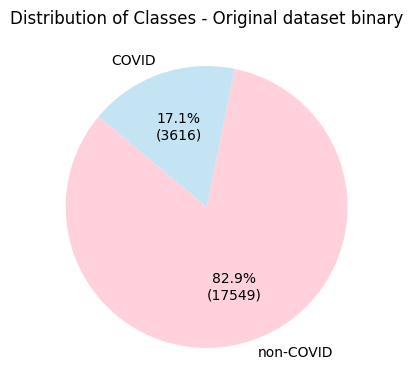

In [ ]:
plot_pie_chart(binary_df, 'Label', 'Distribution of Classes - Original dataset binary')

## Binary + CLAHE

In [ ]:
# Specify output directory for CLAHE-processed images
binary_CLAHE_dir = Path("/content/binary_CLAHE")

# Apply CLAHE to all images in the dataframe
apply_clahe_to_images(binary_df, binary_CLAHE_dir, clip_limit=2.0, tile_grid_size=(8, 8), extension='png')

print("CLAHE processing completed. Processed images saved to:", binary_CLAHE_dir)

CLAHE processing completed. Processed images saved to: /content/binary_CLAHE


In [ ]:
# Create dataframe for original dataset
binary_CLAHE_df = create_shuffled_dataframe(binary_CLAHE_dir)
print(binary_CLAHE_df.head())

                                            Filepath      Label
0   /content/binary_CLAHE/COVID/COVID-2696_clahe.png      COVID
1  /content/binary_CLAHE/non-COVID/Normal-3805_cl...  non-COVID
2  /content/binary_CLAHE/non-COVID/Normal-7530_cl...  non-COVID
3  /content/binary_CLAHE/non-COVID/Lung_Opacity-2...  non-COVID
4  /content/binary_CLAHE/non-COVID/Normal-6628_cl...  non-COVID


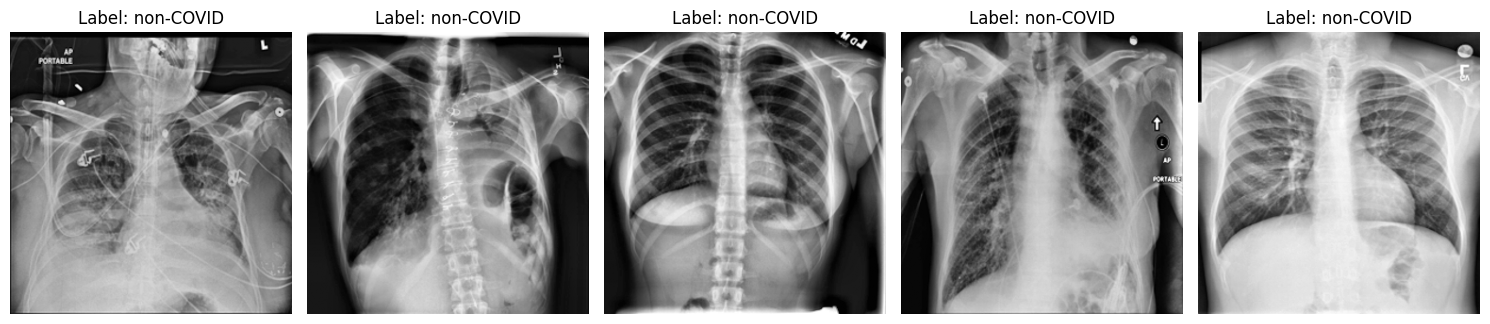

In [ ]:
plot_sample_images(binary_CLAHE_df, num_images=5)

## Binary + Image Complement

In [ ]:
# Specify output directory for Complement-processed images
binary_complement_dir = Path("/content/binary_complement")

# Apply Complement to all images in the dataframe
apply_complement_to_images(binary_df, binary_complement_dir, extension='png')

print("Complement processing completed. Processed images saved to:", binary_complement_dir)

Complement processing completed. Processed images saved to: /content/binary_complement


In [ ]:
# Create dataframe for original dataset
binary_complement_df = create_shuffled_dataframe(binary_complement_dir)
print(binary_complement_df.head())

                                            Filepath      Label
0  /content/binary_complement/COVID/COVID-2622_co...      COVID
1  /content/binary_complement/non-COVID/Viral Pne...  non-COVID
2  /content/binary_complement/non-COVID/Normal-10...  non-COVID
3  /content/binary_complement/non-COVID/Lung_Opac...  non-COVID
4  /content/binary_complement/non-COVID/Normal-38...  non-COVID


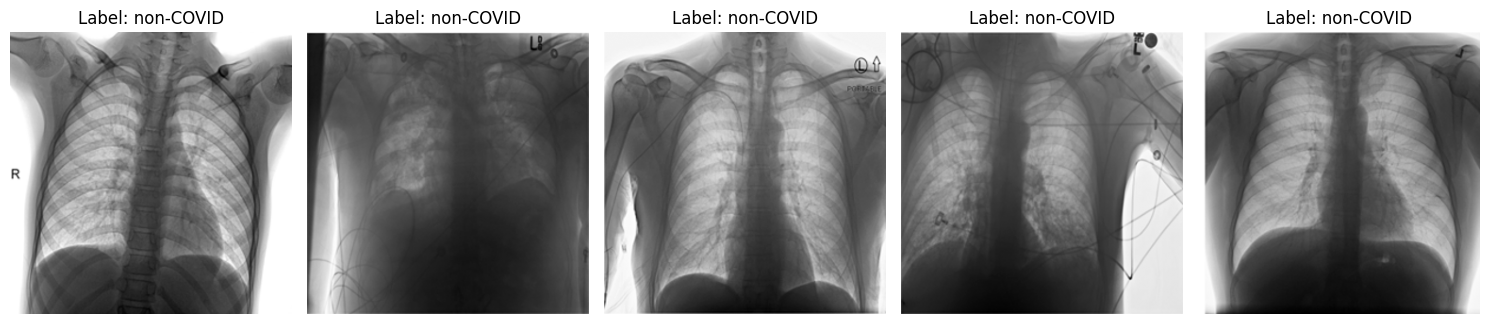

In [ ]:
plot_sample_images(binary_complement_df, num_images=5)

# Splitting all the datasets into training, validation and test sets

In [ ]:
def split_dataset(df, label_column, test_size=0.2, valid_size=0.2, random_state=123):

    # Split into training and test sets
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[label_column])

    # Split the training set further into training and validation sets
    valid_size_adjusted = valid_size / (1 - test_size)  # Adjust validation size based on remaining data
    train_df, valid_df = train_test_split(train_df, test_size=valid_size_adjusted, random_state=random_state, stratify=train_df[label_column])

    # Check the sizes
    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(valid_df)}")
    print(f"Test set size: {len(test_df)}")

    return train_df, valid_df, test_df

In [ ]:
# Original dataset
train, valid, test = split_dataset(df, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 12699
Validation set size: 4233
Test set size: 4233


In [ ]:
# Balanced dataset
train_under, valid_under, test_under = split_dataset(df_balanced, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 3228
Validation set size: 1076
Test set size: 1076


In [ ]:
# Original dataset + mask
train_mask, valid_mask, test_mask = split_dataset(original_masked_df, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 12699
Validation set size: 4233
Test set size: 4233


In [ ]:
# Original + CLAHE
train_CLAHE_orig, valid_CLAHE_orig, test_CLAHE_orig = split_dataset(original_CLAHE_df, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 12699
Validation set size: 4233
Test set size: 4233


In [ ]:
# Original + Image Complement
train_complement_orig, valid_complement_orig, test_complement_orig = split_dataset(original_complement_df, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 12699
Validation set size: 4233
Test set size: 4233


In [ ]:
# Original + Canny
train_canny_orig, valid_canny_orig, test_canny_orig = split_dataset(original_canny_df, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 12699
Validation set size: 4233
Test set size: 4233


In [ ]:
# Binary dataset
train_bin, valid_bin, test_bin = split_dataset(binary_df, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 12699
Validation set size: 4233
Test set size: 4233


In [ ]:
# Binary + CLAHE
train_CLAHE_bin, valid_CLAHE_bin, test_CLAHE_bin = split_dataset(binary_CLAHE_df, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 12699
Validation set size: 4233
Test set size: 4233


In [ ]:
# Binary + Image Complement
train_complement_bin, valid_complement_bin, test_complement_bin = split_dataset(binary_complement_df, label_column='Label', test_size=0.2, valid_size=0.2, random_state=123)

Train set size: 12699
Validation set size: 4233
Test set size: 4233


# Data generators

In [ ]:
def prepare_data_generators(train_df, valid_df, test_df, batch_size, model_type=None):
    """
    Prepares data generators for training, validation, and testing from input dataframes.
    Converts image file paths and labels into tensors that can be fed into a machine learning model.
    Handles grayscale-to-RGB conversion for models like VGG19.

    Args:
    - train_df (pd.DataFrame): Training dataframe with 'Filepath' and 'Label' columns.
    - valid_df (pd.DataFrame): Validation dataframe with 'Filepath' and 'Label' columns.
    - test_df (pd.DataFrame): Test dataframe with 'Filepath' and 'Label' columns.
    - batch_size (int): Batch size for the generators.
    - model_type (str, optional): Specify the model type (e.g., 'vgg19') if special preprocessing is needed.

    Returns:
    - train_generator, validation_generator, test_generator: Data generators for training, validation, and testing.
    """

    # Image properties
    image_size = (224, 224)  # Dimensions to resize images

    # Determine color mode based on the model
    if model_type == 'vgg19':
        color_mode = 'rgb'  # Convert grayscale to 3 channels
    else:
        color_mode = 'grayscale'  # Default to grayscale

    def preprocess_function(img):
        """Custom preprocessing for models like VGG19."""
        if model_type == 'vgg19' and img.shape[-1] == 1:  # Grayscale input
            img = np.repeat(img, 3, axis=-1)  # Duplicate grayscale channel to RGB
        return img

    # Create data augmenters
    train_augmenter = ImageDataGenerator(preprocessing_function=preprocess_function)
    test_augmenter = ImageDataGenerator(preprocessing_function=preprocess_function)

    # Create the training data generator
    train_generator = train_augmenter.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=image_size,
        color_mode=color_mode,
        class_mode='categorical',
        shuffle=True,
        seed=42,
        batch_size=batch_size
    )

    # Create the validation data generator
    validation_generator = test_augmenter.flow_from_dataframe(
        dataframe=valid_df,
        x_col='Filepath',
        y_col='Label',
        target_size=image_size,
        color_mode=color_mode,
        class_mode='categorical',
        shuffle=False,
        seed=42,
        batch_size=batch_size
    )

    # Create the test data generator
    test_generator = test_augmenter.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=image_size,
        color_mode=color_mode,
        class_mode='categorical',
        shuffle=False,
        batch_size=batch_size
    )

    return train_generator, validation_generator, test_generator

In [ ]:
# Batch size for generators
batch_size = 32

In [ ]:
# Original
train_gen, valid_gen, test_gen = prepare_data_generators(train, valid, test, batch_size)
train_gen_3, valid_gen_3, test_gen_3 = prepare_data_generators(train, valid, test, batch_size, model_type='vgg19')

Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.


In [ ]:
# Original
train_under_gen, valid_under_gen, test_under_gen = prepare_data_generators(train_under, valid_under, test_under, batch_size)
train_under_gen_3, valid_under_gen_3, test_under_gen_3 = prepare_data_generators(train_under, valid_under, test_under, batch_size, model_type='vgg19')

Found 3228 validated image filenames belonging to 4 classes.
Found 1076 validated image filenames belonging to 4 classes.
Found 1076 validated image filenames belonging to 4 classes.
Found 3228 validated image filenames belonging to 4 classes.
Found 1076 validated image filenames belonging to 4 classes.
Found 1076 validated image filenames belonging to 4 classes.


In [ ]:
# Original + mask
train_mask_gen, valid_mask_gen, test_mask_gen = prepare_data_generators(train_mask, valid_mask, test_mask, batch_size)
train_mask_gen_3, valid_mask_gen_3, test_mask_gen_3 = prepare_data_generators(train_mask, valid_mask, test_mask, batch_size, model_type='vgg19')

Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.


In [ ]:
# Original + CLAHE
train_gen_CLAHE_orig, valid_gen_CLAHE_orig, test_gen_CLAHE_orig = prepare_data_generators(train_CLAHE_orig, valid_CLAHE_orig, test_CLAHE_orig, batch_size)
train_gen_CLAHE_orig_3, valid_gen_CLAHE_orig_3, test_gen_CLAHE_orig_3 = prepare_data_generators(train_CLAHE_orig, valid_CLAHE_orig, test_CLAHE_orig, batch_size, model_type='vgg19')

Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.


In [ ]:
# Original + Complement Image
train_compl_gen, valid_compl_gen, test_compl_gen = prepare_data_generators(train_complement_orig, valid_complement_orig, test_complement_orig, batch_size)
train_compl_gen_3, valid_compl_gen_3, test_compl_gen_3 = prepare_data_generators(train_complement_orig, valid_complement_orig, test_complement_orig, batch_size, model_type='vgg19')

Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.


In [ ]:
# Original + Canny
train_canny_gen, valid_canny_gen, test_canny_gen = prepare_data_generators(train_canny_orig, valid_canny_orig, test_canny_orig, batch_size)
train_canny_gen_3, valid_canny_gen_3, test_canny_gen_3 = prepare_data_generators(train_canny_orig, valid_canny_orig, test_canny_orig, batch_size, model_type='vgg19')

Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.


In [ ]:
# Binary
train_bin_gen, valid_bin_gen, test_bin_gen = prepare_data_generators(train_bin, valid_bin, test_bin, batch_size)
train_bin_gen_3, valid_bin_gen_3, test_bin_gen_3 = prepare_data_generators(train_bin, valid_bin, test_bin, batch_size, model_type='vgg19')

Found 12699 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 12699 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.


In [ ]:
# Binary + CLAHE
train_bin_CLAHE_gen, valid_bin_CLAHE_gen, test_bin_CLAHE_gen = prepare_data_generators(train_CLAHE_bin, valid_CLAHE_bin, test_CLAHE_bin, batch_size)
train_bin_CLAHE_gen_3, valid_bin_CLAHE_gen_3, test_bin_CLAHE_gen_3 = prepare_data_generators(train_CLAHE_bin, valid_CLAHE_bin, test_CLAHE_bin, batch_size, model_type='vgg19')

Found 12699 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 12699 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.


In [ ]:
# Binary + Image Complement
train_bin_compl_gen, valid_bin_compl_gen, test_bin_compl_gen = prepare_data_generators(train_complement_bin, valid_complement_bin, test_complement_bin, batch_size)
train_bin_compl_gen_3, valid_bin_compl_gen_3, test_bin_compl_gen_3 = prepare_data_generators(train_complement_bin, valid_complement_bin, test_complement_bin, batch_size, model_type='vgg19')

Found 12699 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 12699 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.
Found 4233 validated image filenames belonging to 2 classes.


# Multiclass classification

## Covid CNN

### Multiclass model

In [ ]:
def build_cnn(input_shape=(224, 224, 1), n_classes=4):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model

input_shape = (224, 224, 1)
n_classes = 4

model_cnn = build_cnn(input_shape=input_shape, n_classes=n_classes)

opt = keras.optimizers.Adam(learning_rate=1e-4)

model_cnn.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

model_cnn.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,900 (42.61 MB)

 Trainable params: 11,168,900 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Original dataset

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step - Precision: 0.4477 - Recall: 0.1368 - accuracy: 0.4556 - auc_1: 0.6111 - loss: 8.4466 - val_Precision: 0.7954 - val_Recall: 0.3085 - val_accuracy: 0.6180 - val_auc_1: 0.8398 - val_loss: 0.9788
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step - Precision: 0.7197 - Recall: 0.2740 - accuracy: 0.5459 - auc_1: 0.7655 - loss: 1.1361 - val_Precision: 0.8124 - val_Recall: 0.4429 - val_accuracy: 0.6315 - val_auc_1: 0.8627 - val_loss: 0.9218
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - Precision: 0.7633 - Recall: 0.3151 - accuracy: 0.5543 - auc_1: 0.7960 - loss: 1.0645 - val_Precision: 0.8364 - val_Recall: 0.4663 - val_accuracy: 0.6506 - val_auc_1: 0.8940 - val_loss: 0.8403
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - Precision: 0.7723 - Recall: 0.4084 - accuracy: 0.5592 - auc_1: 0.8300 - loss: 0.9637 - val_Precision: 0.8052 - val_Recall: 0.5459 - val_accuracy: 0.6482 - val_auc_1: 0.8994 - val_loss: 0.7805
Epoch 5/30
397/397

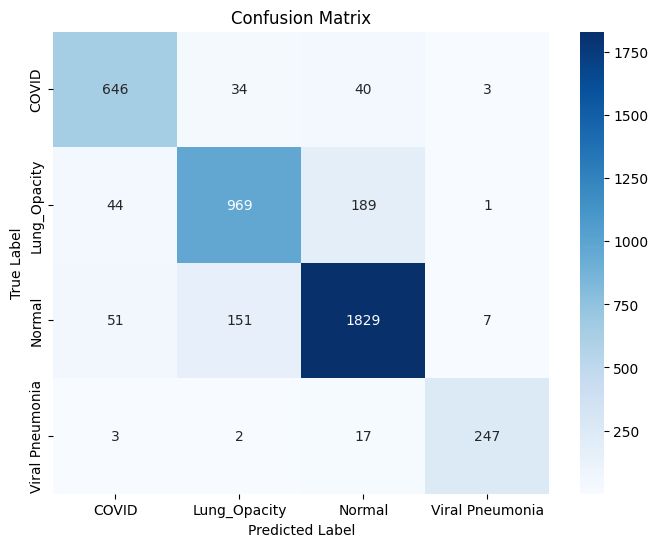

Training history saved to history_cnn_original.csv successfully.


In [ ]:
# Callback

checkpoint_path = "/content/cnn_original.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn = model_cnn.fit(
    train_gen,  # Training data
    validation_data=valid_gen,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn.load_weights(checkpoint_path)

metrics_cnn_orig = evaluate_model(model_cnn, test_gen)
save_training_history(history_cnn, 'history_cnn_original.csv')

### Balanced dataset

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - Precision: 0.3344 - Recall: 0.1753 - accuracy: 0.3189 - auc_6: 0.5585 - loss: 12.0772 - val_Precision: 0.9412 - val_Recall: 0.0297 - val_accuracy: 0.4461 - val_auc_6: 0.7081 - val_loss: 1.2274
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - Precision: 0.6982 - Recall: 0.0558 - accuracy: 0.3084 - auc_6: 0.5925 - loss: 1.3269 - val_Precision: 0.8744 - val_Recall: 0.1617 - val_accuracy: 0.4424 - val_auc_6: 0.6202 - val_loss: 1.6449
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - Precision: 0.8188 - Recall: 0.1046 - accuracy: 0.3641 - auc_6: 0.6192 - loss: 1.3076 - val_Precision: 0.9794 - val_Recall: 0.0883 - val_accuracy: 0.4777 - val_auc_6: 0.6991 - val_loss: 1.2430
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - Precision: 0.7857 - Recall: 0.1327 - accuracy: 0.3734 - auc_6: 0.6591 - loss: 1.2540 - val_Precision: 0.8134 - val_Recall: 0.3281 - val_accuracy: 0.4926 - val_auc_6: 0.8036 - val_loss: 1.0404
Epoch 5/3

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - Precision: 0.8587 - Recall: 0.8336 - accuracy: 0.8491 - auc_6: 0.9580 - loss: 0.5346
Test Loss: 0.5747210383415222
Test Accuracy: 0.8317843675613403
Test Precision: 0.8427612781524658
Test Recall: 0.8169144988059998
Test AUC: 0.9529734253883362
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.86      0.84      0.85       269
   Lung_Opacity       0.77      0.78      0.77       269
         Normal       0.77      0.75      0.76       269
Viral Pneumonia       0.93      0.95      0.94       269

       accuracy                           0.83      1076
      macro avg       0.83      0.83      0.83      1076
   weighted avg       0.83      0.83      0.83      1076



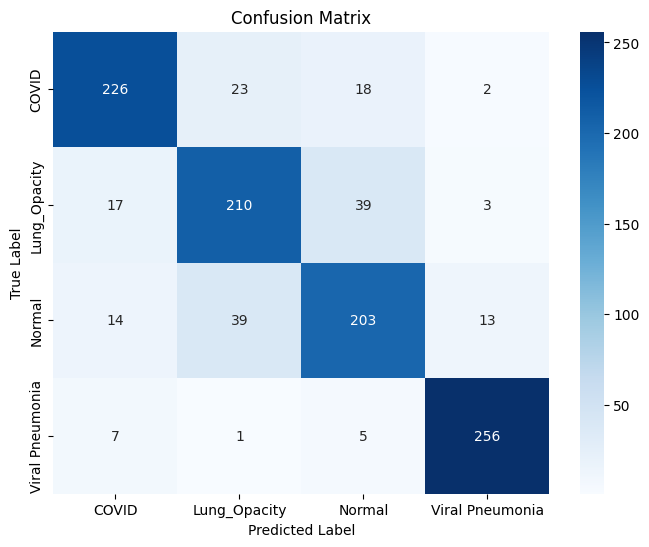

Training history saved to history_cnn_original_balanced.csv successfully.


In [ ]:
model_cnn_under = build_cnn(input_shape=(224, 224, 1), n_classes=4)
model_cnn_under.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

# Callback

checkpoint_path = "/content/cnn_original_balanced.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn_under = model_cnn_under.fit(
    train_under_gen,  # Training data
    validation_data=valid_under_gen,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn_under.load_weights(checkpoint_path)

metrics_cnn_under = evaluate_model(model_cnn_under, test_under_gen)
save_training_history(history_cnn_under, 'history_cnn_original_balanced.csv')

### Original + masks

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - Precision: 0.5689 - Recall: 0.2444 - accuracy: 0.4721 - auc_4: 0.6963 - loss: 4.2924 - val_Precision: 0.8288 - val_Recall: 0.2996 - val_accuracy: 0.6095 - val_auc_4: 0.8458 - val_loss: 0.9738
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - Precision: 0.7644 - Recall: 0.3579 - accuracy: 0.5587 - auc_4: 0.8209 - loss: 1.0061 - val_Precision: 0.8088 - val_Recall: 0.4755 - val_accuracy: 0.6492 - val_auc_4: 0.8787 - val_loss: 0.8459
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - Precision: 0.7832 - Recall: 0.4148 - accuracy: 0.5937 - auc_4: 0.8454 - loss: 0.9309 - val_Precision: 0.8064 - val_Recall: 0.5086 - val_accuracy: 0.6591 - val_auc_4: 0.8846 - val_loss: 0.8146
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - Precision: 0.7869 - Recall: 0.4639 - accuracy: 0.6163 - auc_4: 0.8676 - loss: 0.8659 - val_Precision: 0.7987 - val_Recall: 0.5736 - val_accuracy: 0.6981 - val_auc_4: 0.9041 - val_loss: 0.7510
Epoch 5/

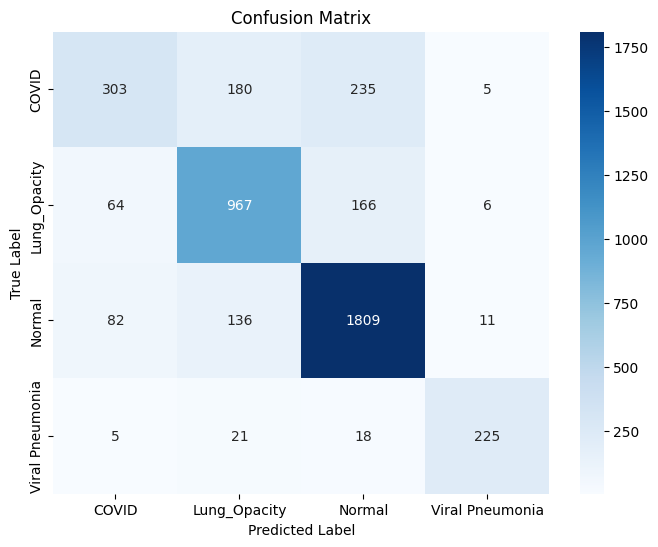

Training history saved to history_cnn_original_masks.csv successfully.


In [ ]:
model_cnn_masks = build_cnn(input_shape=(224, 224, 1), n_classes=4)
model_cnn_masks.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

# Callback

checkpoint_path = "/content/cnn_original_masks.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn_masks = model_cnn_masks.fit(
    train_mask_gen,  # Training data
    validation_data=valid_mask_gen,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn_masks.load_weights(checkpoint_path)

metrics_cnn_masks = evaluate_model(model_cnn_masks, test_mask_gen)
save_training_history(history_cnn_masks, 'history_cnn_original_masks.csv')

### Original + CLAHE

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - Precision: 0.5377 - Recall: 0.1883 - accuracy: 0.4404 - auc_6: 0.6603 - loss: 5.4892 - val_Precision: 0.7306 - val_Recall: 0.3312 - val_accuracy: 0.4817 - val_auc_6: 0.8030 - val_loss: 0.9986
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - Precision: 0.6902 - Recall: 0.2020 - accuracy: 0.4798 - auc_6: 0.7475 - loss: 1.1742 - val_Precision: 0.8297 - val_Recall: 0.2405 - val_accuracy: 0.4817 - val_auc_6: 0.8019 - val_loss: 1.0438
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - Precision: 0.6991 - Recall: 0.2107 - accuracy: 0.4786 - auc_6: 0.7520 - loss: 1.1542 - val_Precision: 0.7842 - val_Recall: 0.3950 - val_accuracy: 0.4817 - val_auc_6: 0.8170 - val_loss: 0.9746
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - Precision: 0.7266 - Recall: 0.2290 - accuracy: 0.4896 - auc_6: 0.7673 - loss: 1.1264 - val_Precision: 0.8293 - val_Recall: 0.5119 - val_accuracy: 0.6430 - val_auc_6: 0.8589 - val_loss: 0.8909
Epoch 5/30
397/397 

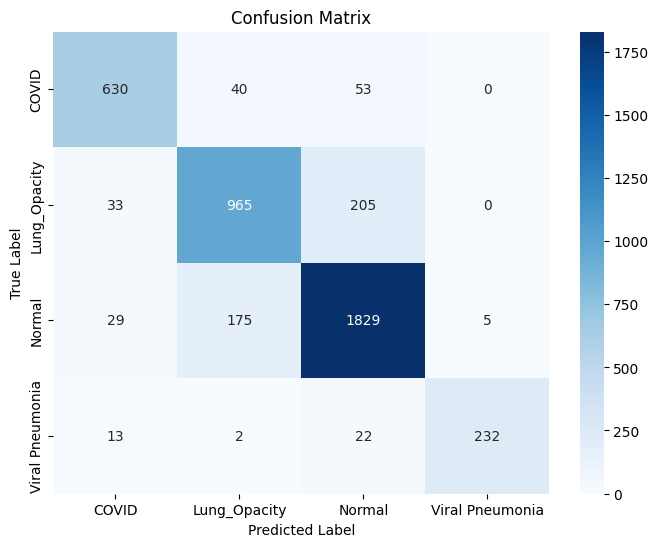

Training history saved to history_cnn_original_CLAHE.csv successfully.


In [ ]:
model_cnn_CLAHE = build_cnn(input_shape=(224, 224, 1), n_classes=4)
model_cnn_CLAHE.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

# Callback

checkpoint_path = "/content/cnn_original_CLAHE.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn_CLAHE = model_cnn_CLAHE.fit(
    train_gen_CLAHE_orig,  # Training data
    validation_data=valid_gen_CLAHE_orig,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn_CLAHE.load_weights(checkpoint_path)

metrics_cnn_CLAHE = evaluate_model(model_cnn_CLAHE, test_gen_CLAHE_orig)
save_training_history(history_cnn_CLAHE, 'history_cnn_original_CLAHE.csv')

### Original + Image Complement

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - Precision: 0.6192 - Recall: 0.3212 - accuracy: 0.4982 - auc_11: 0.7232 - loss: 5.0464 - val_Precision: 0.8372 - val_Recall: 0.4044 - val_accuracy: 0.6171 - val_auc_11: 0.8742 - val_loss: 0.9130
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - Precision: 0.7732 - Recall: 0.3971 - accuracy: 0.5609 - auc_11: 0.8241 - loss: 0.9906 - val_Precision: 0.8053 - val_Recall: 0.5471 - val_accuracy: 0.6414 - val_auc_11: 0.8894 - val_loss: 0.8074
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - Precision: 0.7804 - Recall: 0.4250 - accuracy: 0.5716 - auc_11: 0.8420 - loss: 0.9371 - val_Precision: 0.8028 - val_Recall: 0.5712 - val_accuracy: 0.6489 - val_auc_11: 0.8984 - val_loss: 0.7689
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - Precision: 0.7846 - Recall: 0.4652 - accuracy: 0.6030 - auc_11: 0.8605 - loss: 0.8823 - val_Precision: 0.8386 - val_Recall: 0.6591 - val_accuracy: 0.7841 - val_auc_11: 0.9375 - val_loss: 0.6259


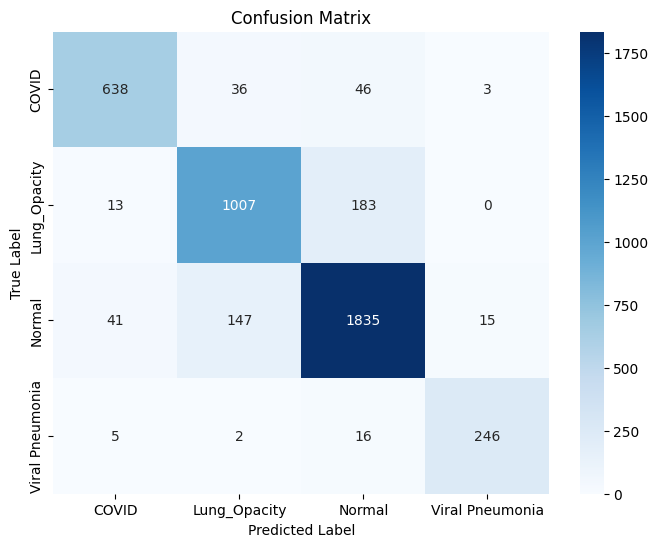

Training history saved to history_cnn_original_compl.csv successfully.


In [ ]:
model_cnn_compl = build_cnn(input_shape=(224, 224, 1), n_classes=4)
model_cnn_compl.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

# Callback

checkpoint_path = "/content/cnn_original_compl.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn_compl = model_cnn_compl.fit(
    train_compl_gen,  # Training data
    validation_data=valid_compl_gen,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn_compl.load_weights(checkpoint_path)

metrics_cnn_compl = evaluate_model(model_cnn_compl, test_compl_gen)
save_training_history(history_cnn_compl, 'history_cnn_original_compl.csv')

### Original + Canny

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - Precision: 0.5204 - Recall: 0.1341 - accuracy: 0.4672 - auc_2: 0.6420 - loss: 9.7974 - val_Precision: 0.8457 - val_Recall: 0.0699 - val_accuracy: 0.6031 - val_auc_2: 0.7471 - val_loss: 1.2766
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - Precision: 0.6723 - Recall: 0.0721 - accuracy: 0.5385 - auc_2: 0.7332 - loss: 1.3048 - val_Precision: 0.8681 - val_Recall: 0.0591 - val_accuracy: 0.6232 - val_auc_2: 0.7933 - val_loss: 1.2570
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - Precision: 0.7249 - Recall: 0.0964 - accuracy: 0.5536 - auc_2: 0.7556 - loss: 1.2603 - val_Precision: 0.6667 - val_Recall: 0.1857 - val_accuracy: 0.5433 - val_auc_2: 0.7656 - val_loss: 1.1789
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - Precision: 0.7009 - Recall: 0.1037 - accuracy: 0.5539 - auc_2: 0.7565 - loss: 1.2342 - val_Precision: 0.9148 - val_Recall: 0.0380 - val_accuracy: 0.6182 - val_auc_2: 0.7923 - val_loss: 1.2304
Epoch 5/30
397/397 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


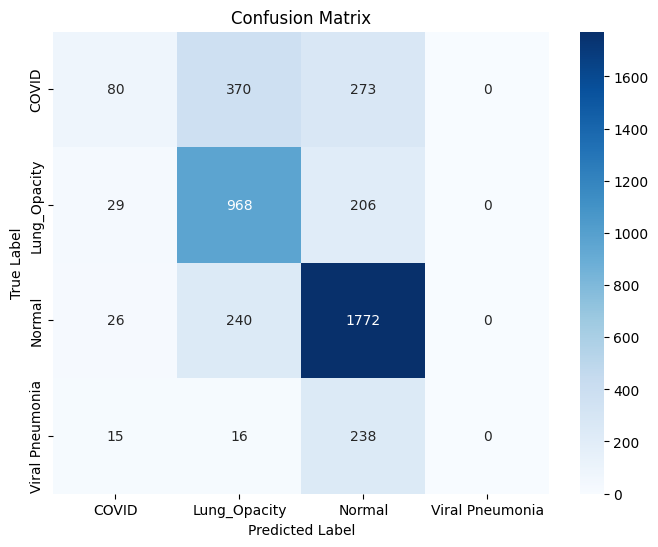

Training history saved to history_cnn_original_canny.csv successfully.


In [ ]:
model_cnn_canny = build_cnn(input_shape=(224, 224, 1), n_classes=4)
model_cnn_canny.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

# Callback

checkpoint_path = "/content/cnn_original_canny.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn_canny = model_cnn_canny.fit(
    train_canny_gen,  # Training data
    validation_data=valid_canny_gen,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn_canny.load_weights(checkpoint_path)

metrics_cnn_canny = evaluate_model(model_cnn_canny, test_canny_gen)
save_training_history(history_cnn_canny, 'history_cnn_original_canny.csv')

## VGG19

### Multiclass model

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_vgg19_model(input_shape=(224, 224, 3), num_classes=4, freeze_layers=15):
    # Use the pretrained VGG19 base model without the top layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze some of the layers after initial training
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Add custom classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization
    x = Dropout(0.5)(x)  # Dropout layer
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization
    x = Dropout(0.5)(x)  # Dropout layer
    output = Dense(num_classes, activation='softmax')(x)  # Output layer for 4 classes

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with an optimizer and loss function suitable for multi-class classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build and compile the VGG19 model
model_vgg19 = build_vgg19_model(input_shape=(224, 224, 3), num_classes=4)
model_vgg19.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

model_vgg19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,482,116 (101.02 MB)

 Trainable params: 18,256,004 (69.64 MB)

 Non-trainable params: 8,226,112 (31.38 MB)

### Original dataset

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 62s 130ms/step - accuracy: 0.6051 - auc: 0.8179 - loss: 1.2244 - precision: 0.6437 - recall: 0.5554 - val_accuracy: 0.7139 - val_auc: 0.9174 - val_loss: 1.1229 - val_precision: 0.7428 - val_recall: 0.6787
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8476 - auc: 0.9660 - loss: 0.4292 - precision: 0.8658 - recall: 0.8330 - val_accuracy: 0.8202 - val_auc: 0.9549 - val_loss: 252.4926 - val_precision: 0.8274 - val_recall: 0.8120
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.8890 - auc: 0.9787 - loss: 0.3263 - precision: 0.8980 - recall: 0.8790 - val_accuracy: 0.9069 - val_auc: 0.9834 - val_loss: 0.2881 - val_precision: 0.9118 - val_recall: 0.9039
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.9042 - auc: 0.9848 - loss: 0.2756 - precision: 0.9093 - recall: 0.8947 - val_accuracy: 0.9135 - val_auc: 0.9883 - val_loss: 0.2404 - val_precis

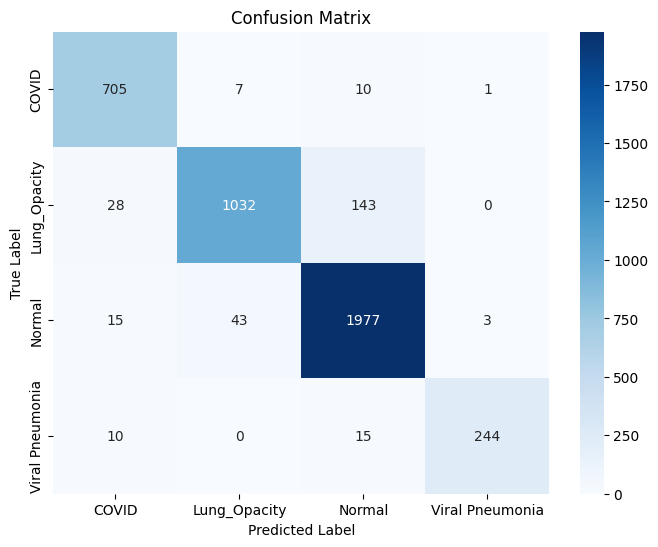

Training history saved to history_vgg19_original.csv successfully.


In [ ]:
# Callback

checkpoint_path = "/content/vgg_original.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_vgg19_orig = model_vgg19.fit(
    train_gen_3,
    validation_data=valid_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19.load_weights(checkpoint_path)

metrics_vgg_orig = evaluate_model(model_vgg19, test_gen_3)
save_training_history(history_vgg19_orig, 'history_vgg19_original.csv')

### Balanced dataset

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - accuracy: 0.5027 - auc: 0.7426 - loss: 1.5466 - precision: 0.5335 - recall: 0.4439 - val_accuracy: 0.4535 - val_auc: 0.6724 - val_loss: 18.3265 - val_precision: 0.4547 - val_recall: 0.4433
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.7360 - auc: 0.9215 - loss: 0.7106 - precision: 0.7583 - recall: 0.7140 - val_accuracy: 0.8095 - val_auc: 0.9431 - val_loss: 2.4646 - val_precision: 0.8207 - val_recall: 0.8039
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.8318 - auc: 0.9565 - loss: 0.5077 - precision: 0.8442 - recall: 0.8135 - val_accuracy: 0.6849 - val_auc: 0.9033 - val_loss: 16.6066 - val_precision: 0.6958 - val_recall: 0.6738
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.8650 - auc: 0.9711 - loss: 0.3931 - precision: 0.8771 - recall: 0.8508 - val_accuracy: 0.7918 - val_auc: 0.9397 - val_loss: 0.7685 - val_precision: 0.7979 - val_recall: 0.7890
Epoch 5/30
101/101

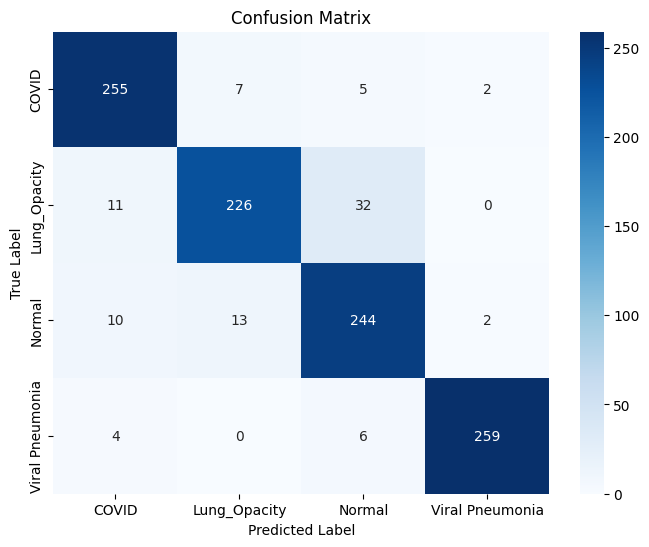

Training history saved to history_vgg19_original_under.csv successfully.


In [ ]:
# Build and compile the VGG19 model
model_vgg19_orig_under = build_vgg19_model(input_shape=(224, 224, 3), num_classes=4)
model_vgg19_orig_under.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Callback

checkpoint_path = "/content/vgg_original_balanced.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_vgg19_orig_under = model_vgg19_orig_under.fit(
    train_under_gen_3,
    validation_data=valid_under_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19_orig_under.load_weights(checkpoint_path)

metrics_vgg_orig_under = evaluate_model(model_vgg19_orig_under, test_under_gen_3)
save_training_history(history_vgg19_orig_under, 'history_vgg19_original_under.csv')

### Original + masks

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 59s 117ms/step - accuracy: 0.5603 - auc: 0.7877 - loss: 1.3112 - precision: 0.5945 - recall: 0.5029 - val_accuracy: 0.7472 - val_auc: 0.9205 - val_loss: 0.6922 - val_precision: 0.7809 - val_recall: 0.7066
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.7411 - auc: 0.9200 - loss: 0.6877 - precision: 0.7731 - recall: 0.6939 - val_accuracy: 0.8032 - val_auc: 0.9520 - val_loss: 0.5332 - val_precision: 0.8259 - val_recall: 0.7867
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.8083 - auc: 0.9502 - loss: 0.5305 - precision: 0.8324 - recall: 0.7740 - val_accuracy: 0.8042 - val_auc: 0.9559 - val_loss: 0.5194 - val_precision: 0.8173 - val_recall: 0.7907
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.8365 - auc: 0.9647 - loss: 0.4442 - precision: 0.8580 - recall: 0.8135 - val_accuracy: 0.7597 - val_auc: 0.9261 - val_loss: 0.6985 - val_precision: 0.7856 - val_recall: 0.7288
Epoch 5/30
397/397 ━━━━━━━━━━━━━━━

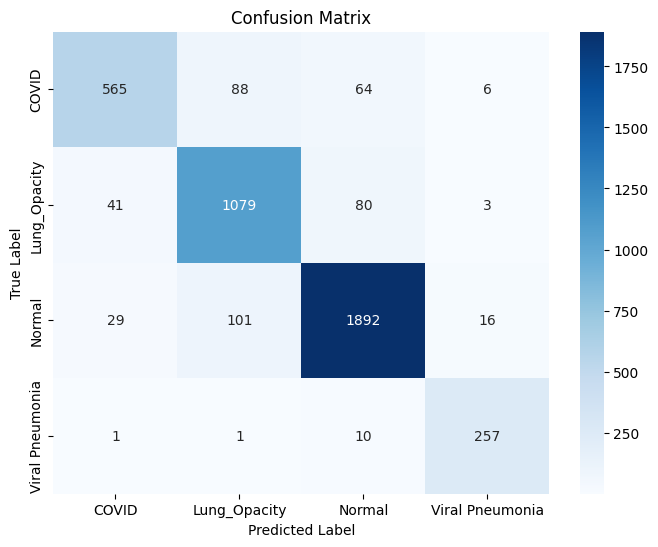

Training history saved to history_vgg19_orig_mask.csv successfully.


In [ ]:
# Build and compile the VGG19 model
model_vgg19_orig_mask = build_vgg19_model(input_shape=(224, 224, 3), num_classes=4)
model_vgg19_orig_mask.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Callback

checkpoint_path = "/content/vgg_original_mask.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_vgg19_orig_masks = model_vgg19_orig_mask.fit(
    train_mask_gen_3,
    validation_data=valid_mask_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19_orig_mask.load_weights(checkpoint_path)

metrics_vgg_orig_mask = evaluate_model(model_vgg19_orig_mask, test_mask_gen_3)
save_training_history(history_vgg19_orig_masks, 'history_vgg19_original_masks.csv')

### Original + CLAHE

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - accuracy: 0.5847 - auc: 0.7994 - loss: 1.2531 - precision: 0.6198 - recall: 0.5293 - val_accuracy: 0.4453 - val_auc: 0.7338 - val_loss: 65.9736 - val_precision: 0.4516 - val_recall: 0.4328
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.8408 - auc: 0.9623 - loss: 0.4531 - precision: 0.8559 - recall: 0.8237 - val_accuracy: 0.5162 - val_auc: 0.7733 - val_loss: 3.1003 - val_precision: 0.5167 - val_recall: 0.5143
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.8905 - auc: 0.9807 - loss: 0.3146 - precision: 0.8996 - recall: 0.8801 - val_accuracy: 0.6709 - val_auc: 0.8782 - val_loss: 1.0135 - val_precision: 0.6830 - val_recall: 0.6525
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9052 - auc: 0.9860 - loss: 0.2655 - precision: 0.9106 - recall: 0.8994 - val_accuracy: 0.7238 - val_auc: 0.9015 - val_loss: 0.9406 - val_precision: 0.7380 - val_recall: 0.7087
Epoch 5/30
397/397 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9268 - auc: 0.9911 - loss: 0.2081 - precision: 0.9285 - recall: 0.9238
Test Loss: 0.21845610439777374
Test Accuracy: 0.9232223033905029
Test Precision: 0.9263132810592651
Test Recall: 0.9206236600875854
Test AUC: 0.9900370836257935
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.89      0.98      0.93       723
   Lung_Opacity       0.91      0.86      0.89      1203
         Normal       0.93      0.94      0.93      2038
Viral Pneumonia       0.98      0.96      0.97       269

       accuracy                           0.92      4233
      macro avg       0.93      0.93      0.93      4233
   weighted avg       0.92      0.92      0.92      4233



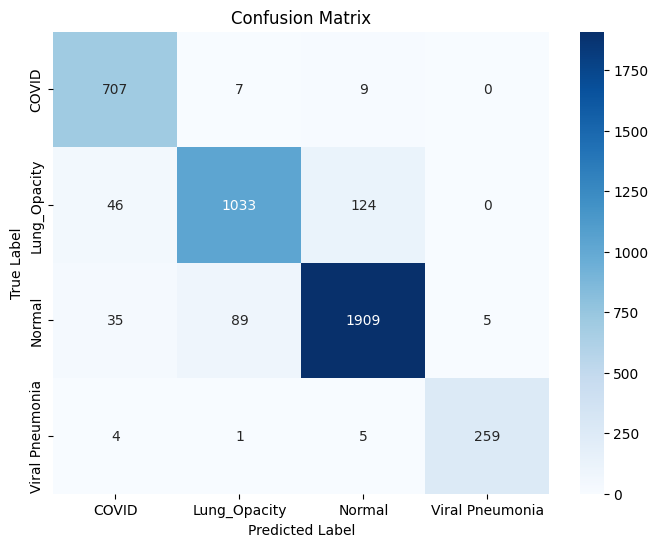

Training history saved to history_vgg19_orig_CLAHE.csv successfully.


In [ ]:
# Build and compile the VGG19 model
model_vgg19_orig_CLAHE = build_vgg19_model(input_shape=(224, 224, 3), num_classes=4)
model_vgg19_orig_CLAHE.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Callback

checkpoint_path = "/content/vgg_original_CLAHE.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_vgg19_orig_CLAHE = model_vgg19.fit(
    train_gen_CLAHE_orig_3,
    validation_data=valid_gen_CLAHE_orig_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19_orig_CLAHE.load_weights(checkpoint_path)

metrics_vgg_CLAHE_orig = evaluate_model(model_vgg19_orig_CLAHE, test_gen_CLAHE_orig_3)
save_training_history(history_vgg19_orig_CLAHE, 'history_vgg19_orig_CLAHE.csv')

133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9329 - auc: 0.9829 - loss: 3.0880 - precision: 0.9335 - recall: 0.9322
Test Loss: 2.596468687057495
Test Accuracy: 0.9336168169975281
Test Precision: 0.9346590638160706
Test Recall: 0.932671844959259
Test AUC: 0.9834102392196655
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.93      0.98      0.96       723
   Lung_Opacity       0.93      0.88      0.91      1203
         Normal       0.93      0.95      0.94      2038
Viral Pneumonia       0.98      0.93      0.96       269

       accuracy                           0.93      4233
      macro avg       0.94      0.94      0.94      4233
   weighted avg       0.93      0.93      0.93      4233



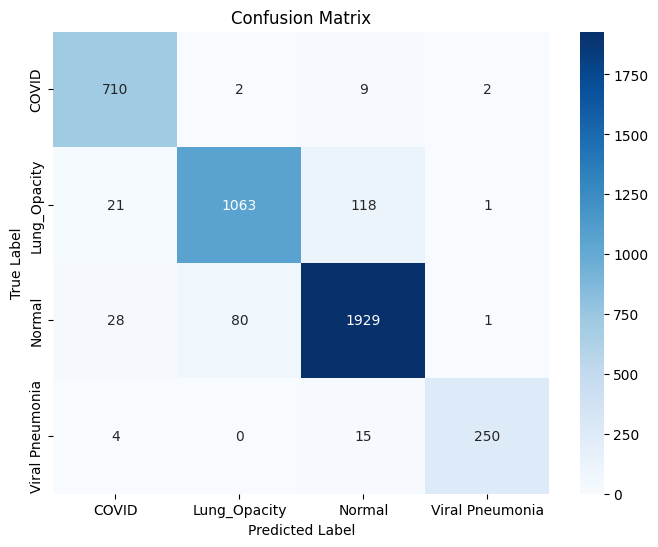

In [ ]:
metrics_vgg_CLAHE_orig = evaluate_model(model_vgg19_orig_CLAHE, test_gen_CLAHE_orig_3)

In [ ]:
save_training_history(history_vgg19_orig_CLAHE, 'history_vgg19_orig_CLAHE.csv')

Training history saved to history_vgg19_orig_CLAHE.csv successfully.


### Original + Image Complement

In [ ]:
# Build and compile the VGG19 model
model_vgg19_orig_compl = build_vgg19_model(input_shape=(224, 224, 3), num_classes=4)
model_vgg19_orig_compl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

checkpoint_path = "/content/vgg_original_compl.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_vgg19_orig_compl = model_vgg19_orig_compl.fit(
    train_compl_gen_3,
    validation_data=valid_compl_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19_orig_compl.load_weights(checkpoint_path)

metrics_vgg_compl = evaluate_model(model_vgg19_orig_compl, test_compl_gen_3)
save_training_history(history_vgg19_orig_compl, 'history_vgg19_original_compl.csv')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 168s 404ms/step - accuracy: 0.4744 - auc: 0.7184 - loss: 1.4931 - precision: 0.5273 - recall: 0.3995 - val_accuracy: 0.5963 - val_auc: 0.8306 - val_loss: 1.0271 - val_precision: 0.6643 - val_recall: 0.5015
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 155s 390ms/step - accuracy: 0.6797 - auc: 0.8823 - loss: 0.8420 - precision: 0.7491 - recall: 0.5934 - val_accuracy: 0.6815 - val_auc: 0.8984 - val_loss: 0.7878 - val_precision: 0.7123 - val_recall: 0.6393
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 155s 390ms/step - accuracy: 0.7276 - auc: 0.9107 - loss: 0.7231 - precision: 0.7814 - recall: 0.6599 - val_accuracy: 0.7942 - val_auc: 0.9510 - val_loss: 0.5275 - val_precision: 0.8186 - val_recall: 0.7588
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 155s 391ms/step - accuracy: 0.7727 - auc: 0.9303 - loss: 0.6322 - precision: 0.8131 - recall: 0.7199 - val_accuracy: 0.7975 - val_auc: 0.9567 - val_loss: 0.5484 - val_precision: 0.8101 - val_recall: 0.7902
Epoch 5/30
397/3

### Original + Canny

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.4934 - auc: 0.7312 - loss: 1.4755 - precision: 0.5326 - recall: 0.4206 - val_accuracy: 0.6688 - val_auc: 0.8759 - val_loss: 0.9313 - val_precision: 0.6909 - val_recall: 0.6558
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.7186 - auc: 0.9037 - loss: 0.7595 - precision: 0.7511 - recall: 0.6645 - val_accuracy: 0.7127 - val_auc: 0.9093 - val_loss: 1.2032 - val_precision: 0.7412 - val_recall: 0.6752
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.7859 - auc: 0.9404 - loss: 0.5822 - precision: 0.8121 - recall: 0.7519 - val_accuracy: 0.4907 - val_auc: 0.7857 - val_loss: 1.5040 - val_precision: 0.4973 - val_recall: 0.4647
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.8126 - auc: 0.9559 - loss: 0.4984 - precision: 0.8320 - recall: 0.7861 - val_accuracy: 0.7101 - val_auc: 0.9117 - val_loss: 0.9530 - val_precision: 0.7166 - val_recall: 0.7026
Epoch 5/30
397/397 ━━━━━━━━━━━━━━━━

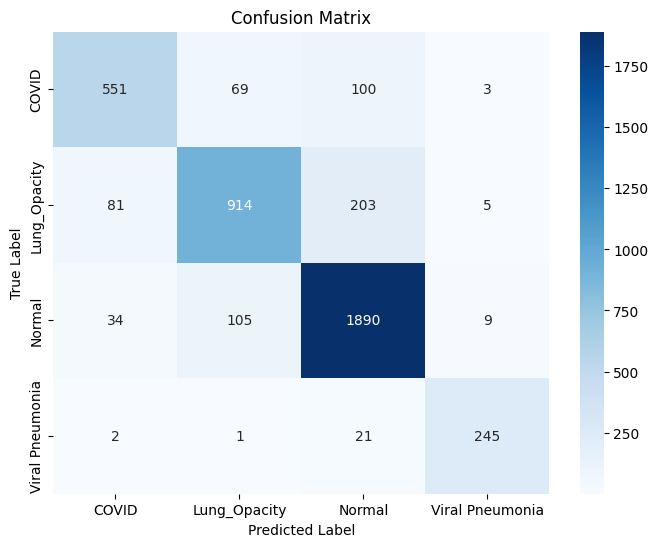

Training history saved to history_vgg19_original_canny.csv successfully.


In [ ]:
# Build and compile the VGG19 model
model_vgg19_orig_canny = build_vgg19_model(input_shape=(224, 224, 3), num_classes=4)
model_vgg19_orig_canny.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

checkpoint_path = "/content/vgg_original_canny.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_vgg19_orig_canny = model_vgg19_orig_canny.fit(
    train_canny_gen_3,
    validation_data=valid_canny_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19_orig_canny.load_weights(checkpoint_path)

metrics_vgg_canny = evaluate_model(model_vgg19_orig_canny, test_canny_gen_3)
save_training_history(history_vgg19_orig_canny, 'history_vgg19_original_canny.csv')

## DenseNet

### Multiclass model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

def build_densenet169_model(input_shape=(224, 224, 3), num_classes=4, freeze_layers=0):
    # Load pre-trained DenseNet169 model without the top layers
    base_model_dn = tf.keras.applications.DenseNet169(
        weights='imagenet',  # Use pre-trained weights from ImageNet
        include_top=False,
        input_shape=input_shape,
        pooling='max'
    )

    # Freeze layers if necessary (based on freeze_layers parameter)
    for layer in base_model_dn.layers[:freeze_layers]:
        layer.trainable = False
    for layer in base_model_dn.layers[freeze_layers:]:
        layer.trainable = True

    # Create the final model by adding the custom classification layer
    model = Sequential([
        base_model_dn,
        Dense(num_classes, activation='softmax')  # Final classification layer
    ])

    return model

# Build and compile the DenseNet169 model
model_dn = build_densenet169_model(input_shape=(224, 224, 3), num_classes=4)

# Define optimizer
opt_dn = Adam(learning_rate=1e-5)

# Compile the model
model_dn.compile(
    optimizer=opt_dn,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
             AUC(num_thresholds=200, curve="ROC", summation_method="interpolation", multi_label=False, from_logits=False)]
)

# Display the model summary
model_dn.summary()

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 1664)                │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │           6,660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,649,540 (48.25 MB)

 Trainable params: 12,491,140 (47.65 MB)

 Non-trainable params: 158,400 (618.75 KB)

### Original dataset

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 449s 538ms/step - accuracy: 0.6638 - auc_11: 0.8520 - loss: 1.3570 - precision: 0.6743 - recall: 0.6447 - val_accuracy: 0.8205 - val_auc_11: 0.9584 - val_loss: 0.5398 - val_precision: 0.8295 - val_recall: 0.8136
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.9088 - auc_11: 0.9866 - loss: 0.2533 - precision: 0.9158 - recall: 0.9033 - val_accuracy: 0.8575 - val_auc_11: 0.9685 - val_loss: 0.4391 - val_precision: 0.8639 - val_recall: 0.8516
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.9718 - auc_11: 0.9984 - loss: 0.0906 - precision: 0.9730 - recall: 0.9695 - val_accuracy: 0.8757 - val_auc_11: 0.9742 - val_loss: 0.4043 - val_precision: 0.8801 - val_recall: 0.8720
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.9875 - auc_11: 0.9997 - loss: 0.0491 - precision: 0.9882 - recall: 0.9864 - val_accuracy: 0.8833 - val_auc_11: 0.9769 - val_loss: 0.3762 - val_precision: 0.8859 - val_recall: 0.8805
Epoch 

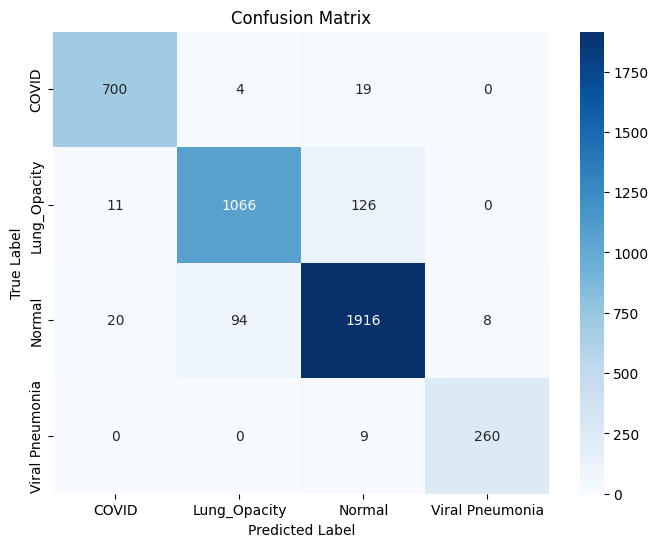

Training history saved to history_dn_original.csv successfully.


In [ ]:
# Callback

checkpoint_path = "/content/dn_original.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn = model_dn.fit(
    train_gen_3,
    validation_data=valid_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn.load_weights(checkpoint_path)

metrics_dn_orig = evaluate_model(model_dn, test_gen_3)
save_training_history(history_dn, 'history_dn_original.csv')

### Balanced dataset

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.4316 - auc_1: 0.6744 - loss: 2.2511 - precision: 0.4507 - recall: 0.4114 - val_accuracy: 0.6301 - val_auc_1: 0.8452 - val_loss: 1.2535 - val_precision: 0.6524 - val_recall: 0.6106
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.8597 - auc_1: 0.9742 - loss: 0.3860 - precision: 0.8766 - recall: 0.8467 - val_accuracy: 0.7649 - val_auc_1: 0.9295 - val_loss: 0.7362 - val_precision: 0.7836 - val_recall: 0.7472
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.9554 - auc_1: 0.9961 - loss: 0.1465 - precision: 0.9619 - recall: 0.9473 - val_accuracy: 0.8206 - val_auc_1: 0.9512 - val_loss: 0.5849 - val_precision: 0.8332 - val_recall: 0.8076
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.9809 - auc_1: 0.9995 - loss: 0.0850 - precision: 0.9851 - recall: 0.9772 - val_accuracy: 0.8336 - val_auc_1: 0.9577 - val_loss: 0.5364 - val_precision: 0.8484 - val_recall: 0.8271
Epoch 

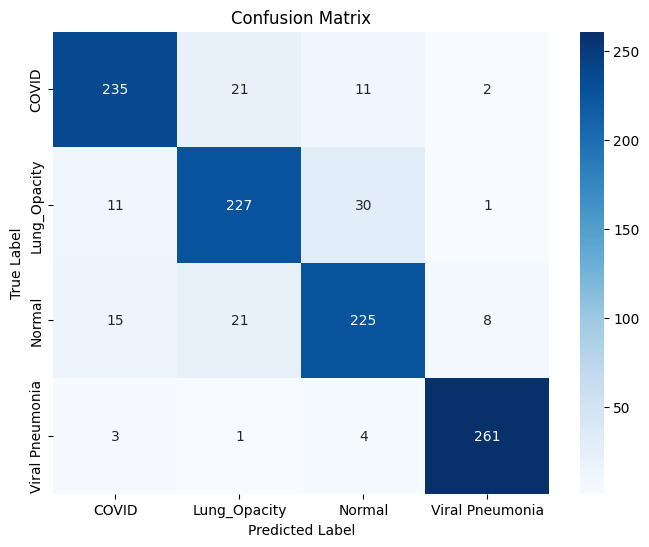

Training history saved to history_dn_balanced.csv successfully.


In [ ]:
# Compile the model
model_dn_under = build_densenet169_model(input_shape=(224, 224, 3), num_classes=4)
model_dn_under.compile(
    optimizer=opt_dn,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(num_thresholds=200, curve="ROC", summation_method="interpolation", multi_label=False, from_logits=False)]
)

# Callback

checkpoint_path = "/content/dn_original_balanced.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn_under = model_dn_under.fit(
    train_under_gen_3,
    validation_data=valid_under_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn_under.load_weights(checkpoint_path)

metrics_dn_masks = evaluate_model(model_dn_under, test_under_gen_3)
save_training_history(history_dn_under, 'history_dn_balanced.csv')

### Original + masks

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 508s 628ms/step - accuracy: 0.6282 - auc_1: 0.8463 - loss: 1.1473 - precision: 0.6516 - recall: 0.6013 - val_accuracy: 0.7690 - val_auc_1: 0.9338 - val_loss: 0.7121 - val_precision: 0.7826 - val_recall: 0.7527
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 47s 117ms/step - accuracy: 0.8500 - auc_1: 0.9710 - loss: 0.4038 - precision: 0.8606 - recall: 0.8382 - val_accuracy: 0.8094 - val_auc_1: 0.9545 - val_loss: 0.5481 - val_precision: 0.8233 - val_recall: 0.7959
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 47s 118ms/step - accuracy: 0.9263 - auc_1: 0.9917 - loss: 0.2085 - precision: 0.9332 - recall: 0.9184 - val_accuracy: 0.8190 - val_auc_1: 0.9562 - val_loss: 0.5417 - val_precision: 0.8324 - val_recall: 0.8105
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 47s 117ms/step - accuracy: 0.9713 - auc_1: 0.9986 - loss: 0.1076 - precision: 0.9748 - recall: 0.9669 - val_accuracy: 0.8363 - val_auc_1: 0.9611 - val_loss: 0.5022 - val_precision: 0.8424 - val_recall: 0.8257
Epoch 5/30
397

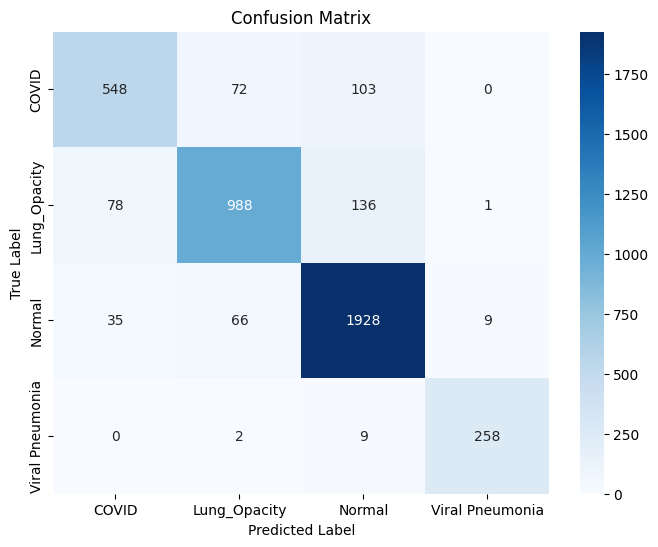

Training history saved to history_dn_masks.csv successfully.


In [ ]:
# Compile the model
model_dn_masks = build_densenet169_model(input_shape=(224, 224, 3), num_classes=4)
model_dn_masks.compile(
    optimizer=opt_dn,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(num_thresholds=200, curve="ROC", summation_method="interpolation", multi_label=False, from_logits=False)]
)

# Callback

checkpoint_path = "/content/dn_original_masked.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn_masks = model_dn_masks.fit(
    train_mask_gen_3,
    validation_data=valid_mask_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn_masks.load_weights(checkpoint_path)

metrics_dn_masks = evaluate_model(model_dn_masks, test_mask_gen_3)
save_training_history(history_dn_masks, 'history_dn_masks.csv')

### Original + CLAHE

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6122 - auc_7: 0.8265 - loss: 1.2931 - precision: 0.6308 - recall: 0.5879

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 451s 546ms/step - accuracy: 0.6125 - auc_7: 0.8267 - loss: 1.2921 - precision: 0.6311 - recall: 0.5882 - val_accuracy: 0.8396 - val_auc_7: 0.9610 - val_loss: 0.5028 - val_precision: 0.8446 - val_recall: 0.8309
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.9058 - auc_7: 0.9861 - loss: 0.2670 - precision: 0.9121 - recall: 0.8990 - val_accuracy: 0.8710 - val_auc_7: 0.9734 - val_loss: 0.3975 - val_precision: 0.8757 - val_recall: 0.8668
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.9691 - auc_7: 0.9982 - loss: 0.1000 - precision: 0.9716 - recall: 0.9661 - val_accuracy: 0.8847 - val_auc_7: 0.9785 - val_loss: 0.3528 - val_precision: 0.8893 - val_recall: 0.8805
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.9873 - auc_7: 0.9997 - loss: 0.0497 - precision: 0.9892 - recall: 0.9862 - val_accuracy: 0.8890 - val_auc_7: 0.9765 - val_loss: 0.3695 - val_precision: 0.8914 - val_recall: 0.8861
Epoch 5/30
397

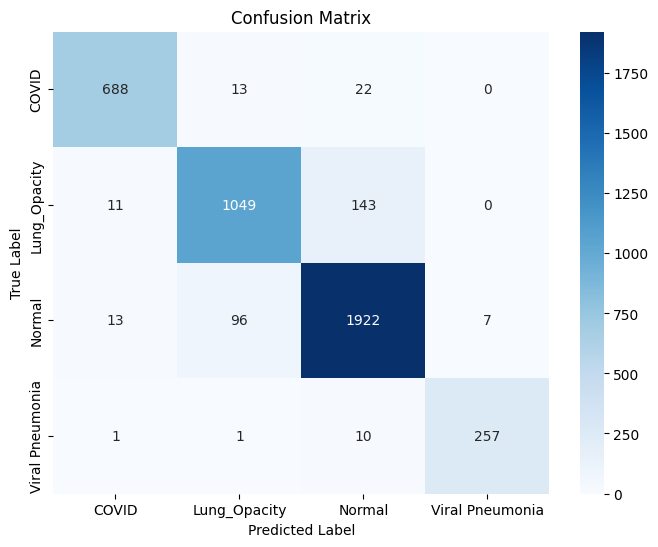

Training history saved to history_dn_CLAHE.csv successfully.


In [ ]:
# Compile the model
model_dn_CLAHE = build_densenet169_model(input_shape=(224, 224, 3), num_classes=4)
model_dn_CLAHE.compile(
    optimizer=opt_dn,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(num_thresholds=200, curve="ROC", summation_method="interpolation", multi_label=False, from_logits=False)]
)

# Callback

checkpoint_path = "/content/dn_original_CLAHE.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn_CLAHE = model_dn_CLAHE.fit(
    train_gen_CLAHE_orig_3,
    validation_data=valid_gen_CLAHE_orig_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn_CLAHE.load_weights(checkpoint_path)

metrics_dn_CLAHE = evaluate_model(model_dn_CLAHE, test_gen_CLAHE_orig_3)
save_training_history(history_dn_CLAHE, 'history_dn_CLAHE.csv')

### Original + Image Complement

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 452s 530ms/step - accuracy: 0.5661 - auc_10: 0.7810 - loss: 1.9465 - precision: 0.5771 - recall: 0.5510 - val_accuracy: 0.8601 - val_auc_10: 0.9659 - val_loss: 0.4615 - val_precision: 0.8666 - val_recall: 0.8547
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.9086 - auc_10: 0.9873 - loss: 0.2507 - precision: 0.9136 - recall: 0.9022 - val_accuracy: 0.8883 - val_auc_10: 0.9762 - val_loss: 0.3601 - val_precision: 0.8957 - val_recall: 0.8845
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.9656 - auc_10: 0.9977 - loss: 0.1038 - precision: 0.9667 - recall: 0.9619 - val_accuracy: 0.9034 - val_auc_10: 0.9798 - val_loss: 0.3215 - val_precision: 0.9080 - val_recall: 0.9001
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.9881 - auc_10: 0.9997 - loss: 0.0498 - precision: 0.9888 - recall: 0.9875 - val_accuracy: 0.9128 - val_auc_10: 0.9810 - val_loss: 0.3012 - val_precision: 0.9159 - val_recall: 0.

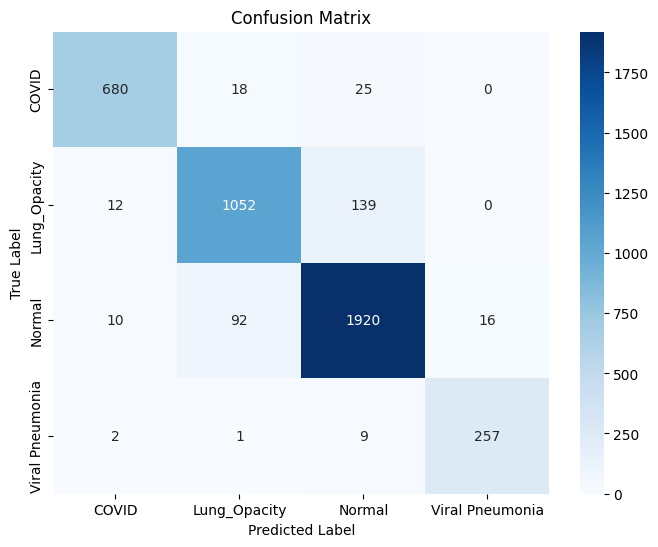

Training history saved to history_dn_compl.csv successfully.


In [ ]:
# Compile the model
model_dn_compl = build_densenet169_model(input_shape=(224, 224, 3), num_classes=4)
model_dn_compl.compile(
    optimizer=opt_dn,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(num_thresholds=200, curve="ROC", summation_method="interpolation", multi_label=False, from_logits=False)]
)

# Callback

checkpoint_path = "/content/dn_original_complement.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn_compl = model_dn_compl.fit(
    train_compl_gen_3,
    validation_data=valid_compl_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn_compl.load_weights(checkpoint_path)

metrics_dn_compl = evaluate_model(model_dn_compl, test_compl_gen_3)
save_training_history(history_dn_compl, 'history_dn_compl.csv')

### Original + Canny

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 481s 578ms/step - accuracy: 0.5105 - auc_1: 0.7468 - loss: 2.0526 - precision: 0.5208 - recall: 0.4909 - val_accuracy: 0.7101 - val_auc_1: 0.9045 - val_loss: 0.8811 - val_precision: 0.7249 - val_recall: 0.6936
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.8231 - auc_1: 0.9612 - loss: 0.4726 - precision: 0.8402 - recall: 0.8086 - val_accuracy: 0.7373 - val_auc_1: 0.9198 - val_loss: 0.7802 - val_precision: 0.7508 - val_recall: 0.7203
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.9373 - auc_1: 0.9934 - loss: 0.1990 - precision: 0.9477 - recall: 0.9275 - val_accuracy: 0.7527 - val_auc_1: 0.9245 - val_loss: 0.7514 - val_precision: 0.7638 - val_recall: 0.7366
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - accuracy: 0.9802 - auc_1: 0.9994 - loss: 0.0919 - precision: 0.9849 - recall: 0.9759 - val_accuracy: 0.7633 - val_auc_1: 0.9302 - val_loss: 0.7424 - val_precision: 0.7756 - val_recall: 0.7519
Epo

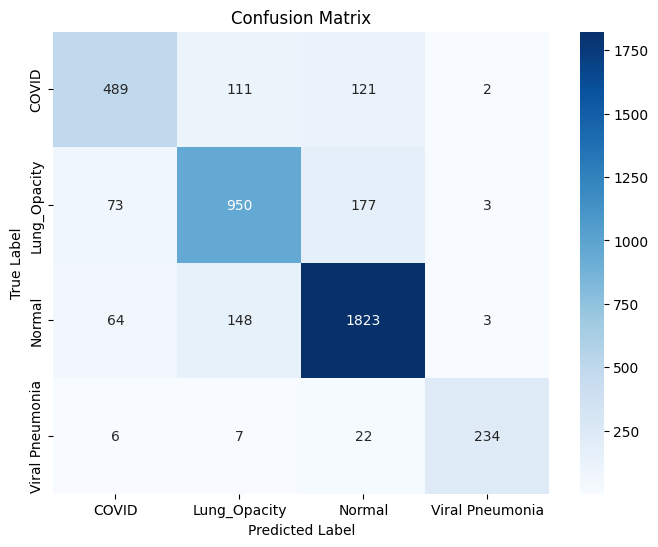

Training history saved to history_dn_canny.csv successfully.


In [ ]:
# Compile the model
model_dn_canny = build_densenet169_model(input_shape=(224, 224, 3), num_classes=4)
model_dn_canny.compile(
    optimizer=opt_dn,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(num_thresholds=200, curve="ROC", summation_method="interpolation", multi_label=False, from_logits=False)]
)

# Callback

checkpoint_path = "/content/dn_original_canny.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn_canny = model_dn_canny.fit(
    train_canny_gen_3,
    validation_data=valid_canny_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn_canny.load_weights(checkpoint_path)

metrics_dn_canny = evaluate_model(model_dn_canny, test_canny_gen_3)
save_training_history(history_dn_canny, 'history_dn_original_canny.csv')

# Binary classification

## Covid CNN

### Binary model

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

def build_cnn_binary(input_shape=(224, 224, 1), n_classes=2):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer (single unit, sigmoid activation for binary classification)
    outputs = Dense(n_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model

# Build the binary CNN model
model_cnn_binary = build_cnn_binary(input_shape=(224, 224, 1), n_classes=2)

# Compile the model with binary_crossentropy loss
opt = Adam(learning_rate=1e-4)

model_cnn_binary.compile(loss="binary_crossentropy",  # Change to binary cross-entropy
                  optimizer=opt,
                  metrics=['accuracy', 'Precision', 'Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

# Display model summary
model_cnn_binary.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,642 (42.60 MB)

 Trainable params: 11,168,642 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

### Binary

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - Precision: 0.7844 - Recall: 0.8053 - accuracy: 0.8062 - auc_17: 0.8373 - loss: 2.4683 - val_Precision: 0.8300 - val_Recall: 0.8283 - val_accuracy: 0.8299 - val_auc_17: 0.9439 - val_loss: 0.3019
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - Precision: 0.8247 - Recall: 0.8254 - accuracy: 0.8253 - auc_17: 0.9336 - loss: 0.3258 - val_Precision: 0.8298 - val_Recall: 0.8292 - val_accuracy: 0.8301 - val_auc_17: 0.9540 - val_loss: 0.2712
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - Precision: 0.8250 - Recall: 0.8714 - accuracy: 0.8370 - auc_17: 0.9508 - loss: 0.2777 - val_Precision: 0.8309 - val_Recall: 0.8309 - val_accuracy: 0.8304 - val_auc_17: 0.9509 - val_loss: 0.4622
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - Precision: 0.8931 - Recall: 0.8963 - accuracy: 0.8950 - auc_17: 0.9611 - loss: 0.2537 - val_Precision: 0.9167 - val_Recall: 0.9235 - val_accuracy: 0.9211 - val_auc_17: 0.9720 - val_loss: 0.2391


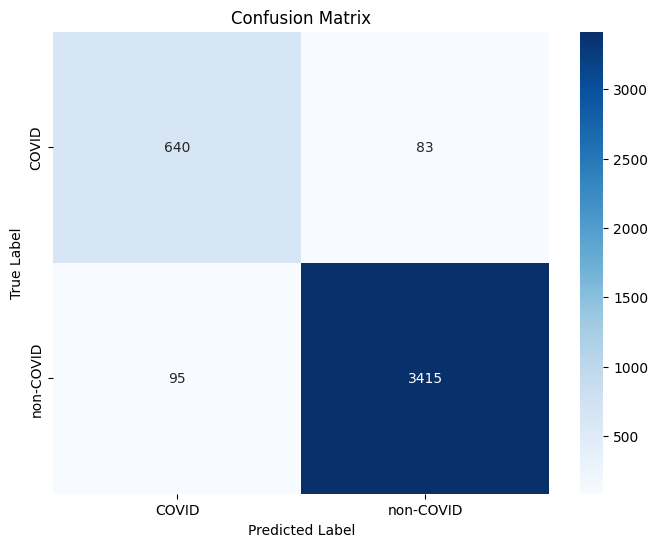

Training history saved to history_cnn_binary.csv successfully.


In [ ]:
# Callback

checkpoint_path = "/content/cnn_binary.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn_bin = model_cnn_binary.fit(
    train_bin_gen,  # Training data
    validation_data=valid_bin_gen,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn_binary.load_weights(checkpoint_path)

metrics_cnn_binary = evaluate_model(model_cnn_binary, test_bin_gen)
save_training_history(history_cnn_bin, 'history_cnn_binary.csv')

### Binary + CLAHE

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - Precision: 0.7954 - Recall: 0.7944 - accuracy: 0.8085 - auc_19: 0.7563 - loss: 1.9476 - val_Precision: 0.8292 - val_Recall: 0.8292 - val_accuracy: 0.8292 - val_auc_19: 0.9371 - val_loss: 0.3314
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - Precision: 0.8343 - Recall: 0.8340 - accuracy: 0.8342 - auc_19: 0.9195 - loss: 0.3669 - val_Precision: 0.8294 - val_Recall: 0.8292 - val_accuracy: 0.8292 - val_auc_19: 0.9450 - val_loss: 0.2979
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - Precision: 0.8374 - Recall: 0.8262 - accuracy: 0.8355 - auc_19: 0.9389 - loss: 0.3043 - val_Precision: 0.9095 - val_Recall: 0.8044 - val_accuracy: 0.8901 - val_auc_19: 0.9628 - val_loss: 0.2639
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - Precision: 0.8675 - Recall: 0.8212 - accuracy: 0.8600 - auc_19: 0.9555 - loss: 0.2587 - val_Precision: 0.8936 - val_Recall: 0.8635 - val_accuracy: 0.8831 - val_auc_19: 0.9609 - val_loss: 0.2791


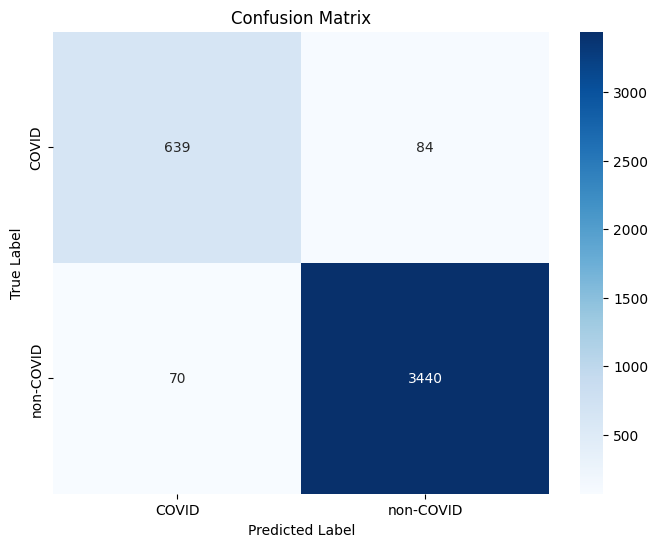

Training history saved to history_cnn_binary_CLAHE.csv successfully.


In [ ]:
# Build the binary CNN model
model_cnn_bin_CLAHE = build_cnn_binary(input_shape=(224, 224, 1), n_classes=2)
model_cnn_bin_CLAHE.compile(loss="binary_crossentropy",  # Change to binary cross-entropy
                  optimizer=opt,
                  metrics=['accuracy', 'Precision', 'Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

# Callback

checkpoint_path = "/content/cnn_binary_CLAHE.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn_bin_CLAHE = model_cnn_bin_CLAHE.fit(
    train_bin_CLAHE_gen,  # Training data
    validation_data=valid_bin_CLAHE_gen,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn_bin_CLAHE.load_weights(checkpoint_path)

metrics_cnn_bin_CLAHE = evaluate_model(model_cnn_bin_CLAHE, test_bin_CLAHE_gen)
save_training_history(history_cnn_bin_CLAHE, 'history_cnn_binary_CLAHE.csv')

### Binary + Image Complement

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - Precision: 0.8017 - Recall: 0.7998 - accuracy: 0.8141 - auc_21: 0.8476 - loss: 1.5089 - val_Precision: 0.8296 - val_Recall: 0.8290 - val_accuracy: 0.8297 - val_auc_21: 0.9477 - val_loss: 0.2952
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - Precision: 0.8352 - Recall: 0.8299 - accuracy: 0.8318 - auc_21: 0.9418 - loss: 0.3106 - val_Precision: 0.8908 - val_Recall: 0.8228 - val_accuracy: 0.8311 - val_auc_21: 0.9562 - val_loss: 0.2673
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - Precision: 0.9083 - Recall: 0.8129 - accuracy: 0.8577 - auc_21: 0.9536 - loss: 0.2753 - val_Precision: 0.9072 - val_Recall: 0.8795 - val_accuracy: 0.8972 - val_auc_21: 0.9681 - val_loss: 0.2276
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - Precision: 0.9096 - Recall: 0.8966 - accuracy: 0.9052 - auc_21: 0.9690 - loss: 0.2305 - val_Precision: 0.9130 - val_Recall: 0.9095 - val_accuracy: 0.9112 - val_auc_21: 0.9733 - val_loss: 0.2159


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - Precision: 0.9671 - Recall: 0.9679 - accuracy: 0.9675 - auc_21: 0.9901 - loss: 0.1458
Test Loss: 0.1529216766357422
Test Accuracy: 0.9692889451980591
Test Precision: 0.9692961573600769
Test Recall: 0.969525158405304
Test AUC: 0.9887672662734985
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step

Classification Report:
              precision    recall  f1-score   support

       COVID       0.94      0.88      0.91       723
   non-COVID       0.98      0.99      0.98      3510

    accuracy                           0.97      4233
   macro avg       0.96      0.93      0.94      4233
weighted avg       0.97      0.97      0.97      4233



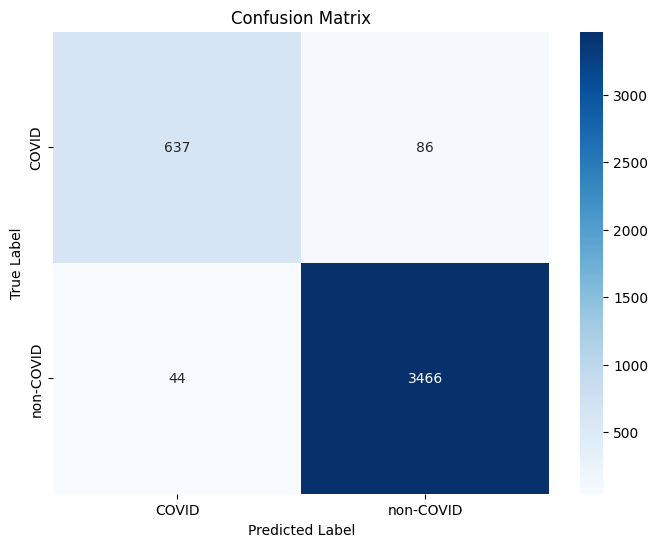

Training history saved to history_cnn_binary_compl.csv successfully.


In [ ]:
# Build the binary CNN model
model_cnn_bin_compl = build_cnn_binary(input_shape=(224, 224, 1), n_classes=2)
model_cnn_bin_compl.compile(loss="binary_crossentropy",  # Change to binary cross-entropy
                  optimizer=opt,
                  metrics=['accuracy', 'Precision', 'Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

# Callback

checkpoint_path = "/content/cnn_binary_compl.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_cnn_bin_compl = model_cnn_bin_compl.fit(
    train_bin_compl_gen,  # Training data
    validation_data=valid_bin_compl_gen,  # Validation data
    epochs=30,  # Number of epochs
    callbacks=keras_callbacks  # Add early stopping callback here
)

model_cnn_bin_compl.load_weights(checkpoint_path)

metrics_cnn_bin_compl = evaluate_model(model_cnn_bin_compl, test_bin_compl_gen)
save_training_history(history_cnn_bin_compl, 'history_cnn_binary_compl.csv')

## VGG19

### Binary model

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_vgg19_binary_model(input_shape=(224, 224, 3), num_classes=2, freeze_layers=15):
    # Use the pretrained VGG19 base model without the top layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze some of the layers after initial training
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Add custom classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization
    x = Dropout(0.5)(x)  # Dropout layer
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization
    x = Dropout(0.5)(x)  # Dropout layer
    output = Dense(num_classes, activation='sigmoid')(x)  # Output layer for binary classification

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with an optimizer and loss function suitable for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build and compile the modified VGG19 model for binary classification
model_vgg19_binary = build_vgg19_binary_model(input_shape=(224, 224, 3), num_classes=2)
model_vgg19_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

model_vgg19_binary.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,481,858 (101.02 MB)

 Trainable params: 18,255,746 (69.64 MB)

 Non-trainable params: 8,226,112 (31.38 MB)

### Binary

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accuracy: 0.7124 - auc: 0.7498 - loss: 0.6242 - precision: 0.6877 - recall: 0.6922 - val_accuracy: 0.9539 - val_auc: 0.9875 - val_loss: 0.1364 - val_precision: 0.9568 - val_recall: 0.9520
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.9436 - auc: 0.9804 - loss: 0.1712 - precision: 0.9395 - recall: 0.9395 - val_accuracy: 0.9568 - val_auc: 0.9892 - val_loss: 0.1253 - val_precision: 0.9550 - val_recall: 0.9584
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.9675 - auc: 0.9938 - loss: 0.0914 - precision: 0.9676 - recall: 0.9676 - val_accuracy: 0.9558 - val_auc: 0.9893 - val_loss: 0.1369 - val_precision: 0.9567 - val_recall: 0.9558
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.9790 - auc: 0.9966 - loss: 0.0625 - precision: 0.9790 - recall: 0.9798 - val_accuracy: 0.9502 - val_auc: 0.9864 - val_loss: 0.1665 - val_precision: 0.9506 - val_recall: 0.9506
Epoch 5/30
397/397 ━

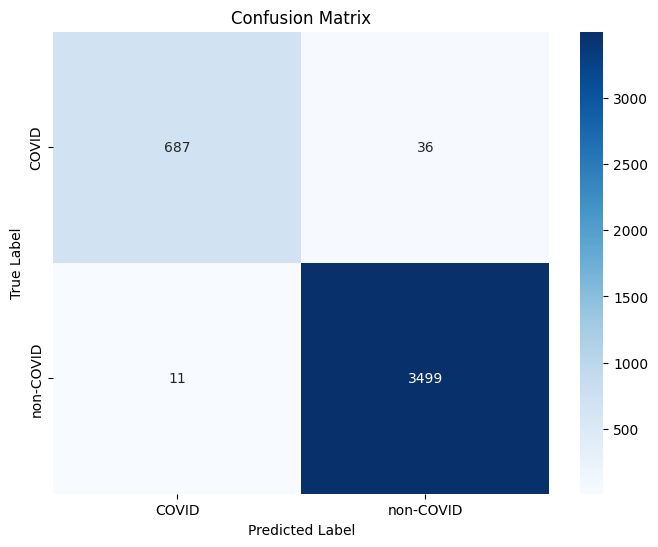

Training history saved to history_vgg19_original_binary.csv successfully.


In [ ]:
# Build and compile the modified VGG19 model for binary classification
model_vgg19_binary = build_vgg19_binary_model(input_shape=(224, 224, 3), num_classes=2)
model_vgg19_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Callback

checkpoint_path = "/content/vgg_binary.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_vgg19_orig_binary = model_vgg19_binary.fit(
    train_bin_gen_3,
    validation_data=valid_bin_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19_binary.load_weights(checkpoint_path)

metrics_vgg_binary = evaluate_model(model_vgg19_binary, test_bin_gen_3)
save_training_history(history_vgg19_orig_binary, 'history_vgg19_original_binary.csv')

### Binary + CLAHE

In [ ]:
# Build and compile the modified VGG19 model for binary classification
model_vgg19_binary_CLAHE = build_vgg19_binary_model(input_shape=(224, 224, 3), num_classes=2)

# Compile the model
model_vgg19_binary_CLAHE.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

In [ ]:
checkpoint_path = "/content/vgg_binary_CLAHE.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_vgg19_CLAHE_binary = model_vgg19_binary_CLAHE.fit(
    train_bin_CLAHE_gen_3,
    validation_data=valid_bin_CLAHE_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19_binary_CLAHE.load_weights(checkpoint_path)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 49s 104ms/step - accuracy: 0.7427 - auc: 0.7745 - loss: 0.6052 - precision: 0.7204 - recall: 0.7079 - val_accuracy: 0.9100 - val_auc: 0.9663 - val_loss: 0.2343 - val_precision: 0.9199 - val_recall: 0.8975
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.9490 - auc: 0.9858 - loss: 0.1450 - precision: 0.9479 - recall: 0.9496 - val_accuracy: 0.9750 - val_auc: 0.9952 - val_loss: 0.0735 - val_precision: 0.9748 - val_recall: 0.9759
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.9692 - auc: 0.9931 - loss: 0.0943 - precision: 0.9690 - recall: 0.9684 - val_accuracy: 0.9532 - val_auc: 0.9866 - val_loss: 0.1401 - val_precision: 0.9506 - val_recall: 0.9549
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.9781 - auc: 0.9963 - loss: 0.0684 - precision: 0.9765 - recall: 0.9770 - val_accuracy: 0.9825 - val_auc: 0.9970 - val_loss: 0.0540 - val_precision: 0.9827 - val_recall: 0.9823
Epoch 5/30
397/397 ━━━━━━━━━━━━━━━

133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9889 - auc: 0.9975 - loss: 0.0880 - precision: 0.9889 - recall: 0.9889
Test Loss: 0.10182172060012817
Test Accuracy: 0.9884243011474609
Test Precision: 0.9886578321456909
Test Recall: 0.9884243011474609
Test AUC: 0.9967453479766846
133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step

Classification Report:
              precision    recall  f1-score   support

       COVID       0.98      0.95      0.97       723
   non-COVID       0.99      1.00      0.99      3510

    accuracy                           0.99      4233
   macro avg       0.99      0.97      0.98      4233
weighted avg       0.99      0.99      0.99      4233



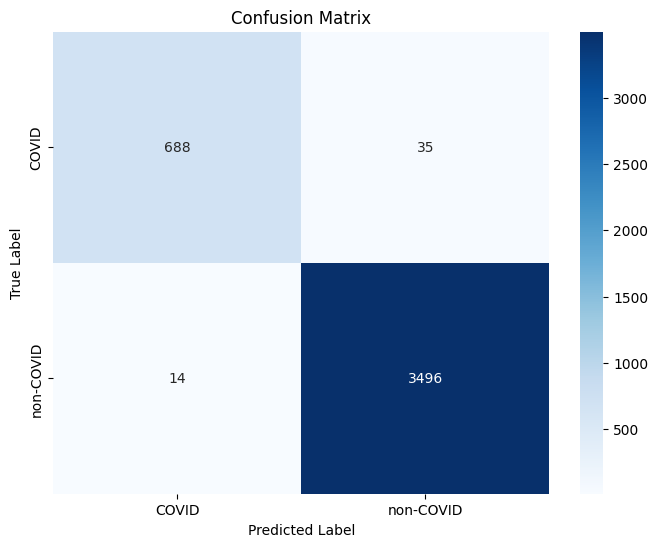

In [ ]:
metrics_vgg_binary_CLAHE = evaluate_model(model_vgg19_binary_CLAHE, test_bin_gen_3)

In [ ]:
save_training_history(history_vgg19_CLAHE_binary, 'history_vgg19_binary_CLAHE.csv')

Training history saved to history_vgg19_binary_CLAHE.csv successfully.


### Binary + Image Complement

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 48s 101ms/step - accuracy: 0.7617 - auc: 0.7952 - loss: 0.5903 - precision: 0.7447 - recall: 0.7238 - val_accuracy: 0.8379 - val_auc: 0.9203 - val_loss: 0.4232 - val_precision: 0.8407 - val_recall: 0.8318
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.9505 - auc: 0.9867 - loss: 0.1399 - precision: 0.9512 - recall: 0.9502 - val_accuracy: 0.9438 - val_auc: 0.9869 - val_loss: 0.1573 - val_precision: 0.9434 - val_recall: 0.9442
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9683 - auc: 0.9945 - loss: 0.0877 - precision: 0.9676 - recall: 0.9673 - val_accuracy: 0.8956 - val_auc: 0.9512 - val_loss: 36.4745 - val_precision: 0.8939 - val_recall: 0.8972
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.9788 - auc: 0.9968 - loss: 0.0621 - precision: 0.9784 - recall: 0.9785 - val_accuracy: 0.9591 - val_auc: 0.9904 - val_loss: 0.1246 - val_precision: 0.9589 - val_recall: 0.9589
Epoch 5/30
397/397 ━━━━━━━━━━━━━━

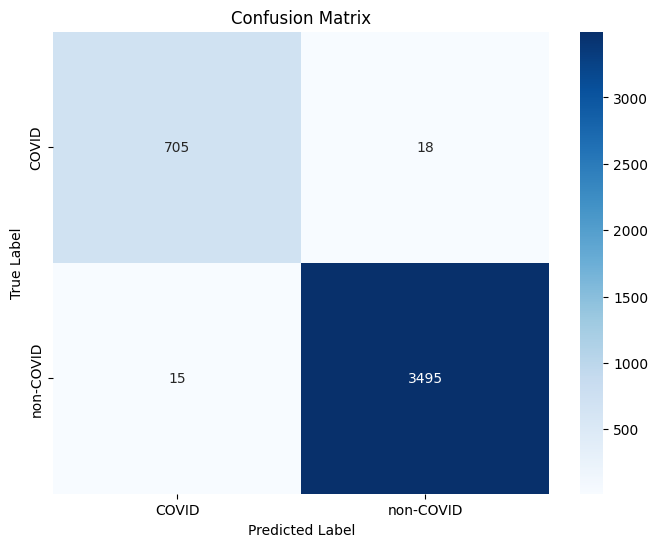

Training history saved to history_vgg19_binary_compl.csv successfully.


In [ ]:
# Build and compile the modified VGG19 model for binary classification
model_vgg19_binary_compl = build_vgg19_binary_model(input_shape=(224, 224, 3), num_classes=2)

# Compile the model
model_vgg19_binary_compl.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Callback

checkpoint_path = "/content/vgg_binary_complement.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

# Train the model
history_vgg19_compl_binary = model_vgg19_binary_compl.fit(
    train_bin_compl_gen_3,
    validation_data=valid_bin_compl_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_vgg19_binary_compl.load_weights(checkpoint_path)

metrics_vgg_binary_compl = evaluate_model(model_vgg19_binary_compl, test_bin_compl_gen_3)
save_training_history(history_vgg19_compl_binary, 'history_vgg19_binary_compl.csv')

## DenseNet

### Binary model

In [ ]:
def build_densenet169_model_binary(input_shape=(224, 224, 3), freeze_layers=0):
    # Load pre-trained DenseNet169 model without the top layers
    base_model_dn = tf.keras.applications.DenseNet169(
        weights='imagenet',  # Use pre-trained weights from ImageNet
        include_top=False,
        input_shape=input_shape,
        pooling='max'
    )

    # Freeze layers if necessary (based on freeze_layers parameter)
    for layer in base_model_dn.layers[:freeze_layers]:
        layer.trainable = False
    for layer in base_model_dn.layers[freeze_layers:]:
        layer.trainable = True

    # Create the final model by adding the custom classification layer
    model = Sequential([
        base_model_dn,
        Dense(2, activation='sigmoid')  # Binary classification (1 neuron + sigmoid)
    ])

    return model

# Build and compile the DenseNet169 model for binary classification
model_dn = build_densenet169_model_binary(input_shape=(224, 224, 3))

# Define optimizer
opt_dn = Adam(learning_rate=1e-5)

# Compile the model for binary classification
model_dn.compile(
    optimizer=opt_dn,
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(name='auc')]  # Simplified AUC metric
)

# Display the model summary
model_dn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 1664)                │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           3,330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,646,210 (48.24 MB)

 Trainable params: 12,487,810 (47.64 MB)

 Non-trainable params: 158,400 (618.75 KB)

### Binary

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7815 - auc: 0.8209 - loss: 0.5998 - precision: 0.7778 - recall: 0.6980

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 463s 552ms/step - accuracy: 0.7818 - auc: 0.8211 - loss: 0.5992 - precision: 0.7780 - recall: 0.6983 - val_accuracy: 0.9591 - val_auc: 0.9864 - val_loss: 0.1459 - val_precision: 0.9512 - val_recall: 0.9442
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.9848 - auc: 0.9970 - loss: 0.0684 - precision: 0.9790 - recall: 0.9788 - val_accuracy: 0.9780 - val_auc: 0.9935 - val_loss: 0.0949 - val_precision: 0.9730 - val_recall: 0.9631
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.9953 - auc: 0.9998 - loss: 0.0278 - precision: 0.9940 - recall: 0.9912 - val_accuracy: 0.9851 - val_auc: 0.9960 - val_loss: 0.0696 - val_precision: 0.9789 - val_recall: 0.9761
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 47s 118ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0127 - precision: 0.9985 - recall: 0.9985 - val_accuracy: 0.9842 - val_auc: 0.9965 - val_loss: 0.0600 - val_precision: 0.9846 - val_recall: 0.9790
Epoch 5/30
397/397 ━━━━━━━━━━━

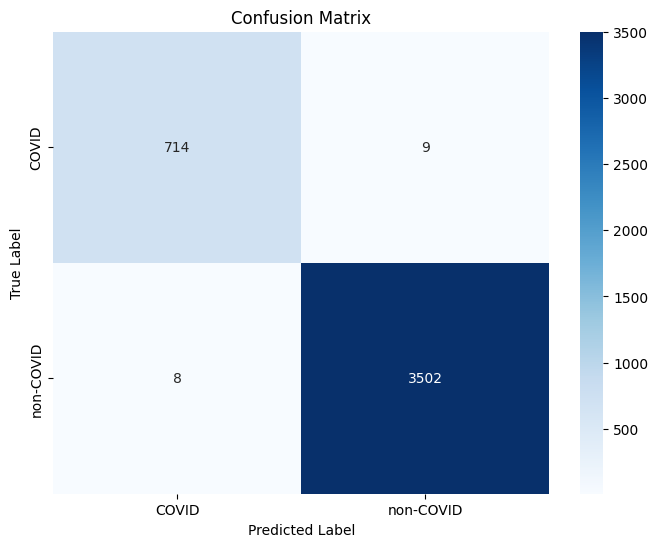

Training history saved to history_dn_bin.csv successfully.


In [ ]:
# Build and compile the DenseNet169 model for binary classification
model_dn_bin = build_densenet169_model_binary(input_shape=(224, 224, 3))
model_dn_bin.compile(
    optimizer=opt_dn,
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(name='auc')]  # Simplified AUC metric
)

# Callback

checkpoint_path = "/content/dn_binary.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn_bin = model_dn_bin.fit(
    train_bin_gen_3,
    validation_data=valid_bin_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn_bin.load_weights(checkpoint_path)

metrics_dn_bin = evaluate_model(model_dn_bin, test_bin_gen_3)
save_training_history(history_dn_bin, 'history_dn_bin.csv')

### Binary + CLAHE

Epoch 1/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 453s 543ms/step - accuracy: 0.8556 - auc: 0.8829 - loss: 0.5192 - precision: 0.8598 - recall: 0.7143 - val_accuracy: 0.9631 - val_auc: 0.9894 - val_loss: 0.1282 - val_precision: 0.9508 - val_recall: 0.9497
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.9833 - auc: 0.9972 - loss: 0.0691 - precision: 0.9765 - recall: 0.9781 - val_accuracy: 0.9811 - val_auc: 0.9958 - val_loss: 0.0774 - val_precision: 0.9706 - val_recall: 0.9733
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.9973 - auc: 0.9999 - loss: 0.0245 - precision: 0.9947 - recall: 0.9945 - val_accuracy: 0.9820 - val_auc: 0.9964 - val_loss: 0.0679 - val_precision: 0.9759 - val_recall: 0.9750
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0.0123 - precision: 0.9991 - recall: 0.9988 - val_accuracy: 0.9830 - val_auc: 0.9973 - val_loss: 0.0581 - val_precision: 0.9797 - val_recall: 0.9797
Epoch 5/30
397/397 

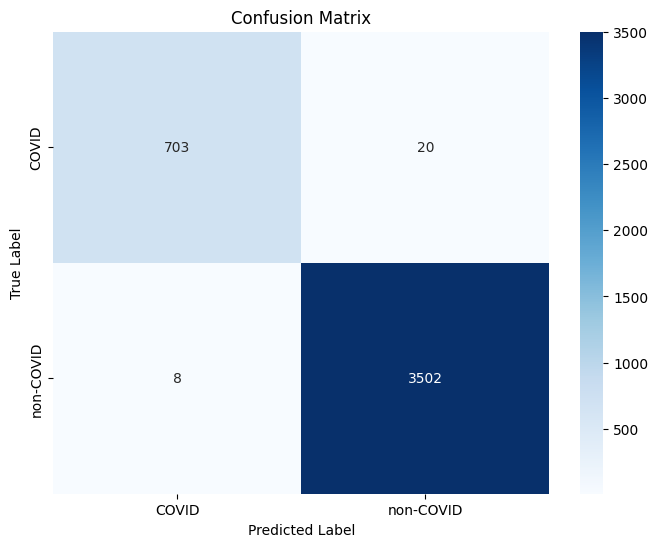

Training history saved to history_dn_binary_CLAHE.csv successfully.


In [ ]:
# Build and compile the DenseNet169 model for binary classification
model_dn_bin_CLAHE = build_densenet169_model_binary(input_shape=(224, 224, 3))
model_dn_bin_CLAHE.compile(
    optimizer=opt_dn,
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(name='auc')]  # Simplified AUC metric
)

# Callback

checkpoint_path = "/content/dn_binary_CLAHE.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn_bin_CLAHE = model_dn_bin_CLAHE.fit(
    train_bin_CLAHE_gen_3,
    validation_data=valid_bin_CLAHE_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn_bin_CLAHE.load_weights(checkpoint_path)

metrics_dn_bin_CLAHE = evaluate_model(model_dn_bin_CLAHE, test_bin_CLAHE_gen_3)
save_training_history(history_dn_bin_CLAHE, 'history_dn_binary_CLAHE.csv')

### Binary + Image Complement

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.9782 - auc: 0.9942 - loss: 0.0843 - precision: 0.9779 - recall: 0.9768 - val_accuracy: 0.9535 - val_auc: 0.9882 - val_loss: 0.1453 - val_precision: 0.9442 - val_recall: 0.9511
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0055 - precision: 0.9985 - recall: 0.9982 - val_accuracy: 0.9884 - val_auc: 0.9983 - val_loss: 0.0377 - val_precision: 0.9863 - val_recall: 0.9868
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 45s 114ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0014 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9950 - val_auc: 0.9992 - val_loss: 0.0197 - val_precision: 0.9946 - val_recall: 0.9941
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0011 - precision: 1.0000 - recall: 0.9994 - val_accuracy: 0.9950 - val_auc: 0.9994 - val_loss: 0.0176 - val_precision: 0.9939 - val_recall: 0.9953
Epoch 5/30
397/397 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1018 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


133/133 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - accuracy: 0.9961 - auc: 0.9999 - loss: 0.0105 - precision: 0.9960 - recall: 0.9956
Test Loss: 0.013308318331837654
Test Accuracy: 0.9955114722251892
Test Precision: 0.9955114722251892
Test Recall: 0.9955114722251892
Test AUC: 0.9995768666267395
133/133 ━━━━━━━━━━━━━━━━━━━━ 36s 169ms/step

Classification Report:
              precision    recall  f1-score   support

       COVID       0.99      0.99      0.99       723
   non-COVID       1.00      1.00      1.00      3510

    accuracy                           1.00      4233
   macro avg       0.99      0.99      0.99      4233
weighted avg       1.00      1.00      1.00      4233



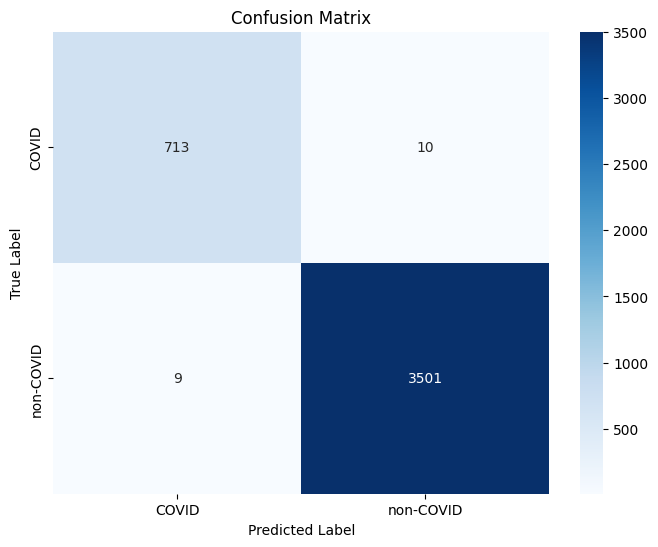

Training history saved to history_dn_binary_compl.csv successfully.


In [ ]:
# Build and compile the DenseNet169 model for binary classification
model_dn_bin_compl = build_densenet169_model_binary(input_shape=(224, 224, 3))
model_dn_bin_compl.compile(
    optimizer=opt_dn,
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
    AUC(name='auc')]  # Simplified AUC metric
)

# Callback

checkpoint_path = "/content/dn_binary_compl.keras"

keras_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=10,             # Stop training after 10 epochs of no improvement
        mode='max',              # Look for maximum accuracy
        min_delta=0.001          # Minimum change to qualify as improvement
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Save weights based on validation accuracy
        save_best_only=True,     # Save only the best weights
        mode='max'               # Look for maximum accuracy
    )
]

history_dn_bin_compl = model_dn_bin_compl.fit(
    train_bin_compl_gen_3,
    validation_data=valid_bin_compl_gen_3,
    epochs=30,
    callbacks=keras_callbacks
)

model_dn_bin_compl.load_weights(checkpoint_path)

metrics_dn_bin_compl = evaluate_model(model_dn_bin_compl, test_bin_compl_gen_3)
save_training_history(history_dn_bin_compl, 'history_dn_binary_compl.csv')

# Results and comparisons

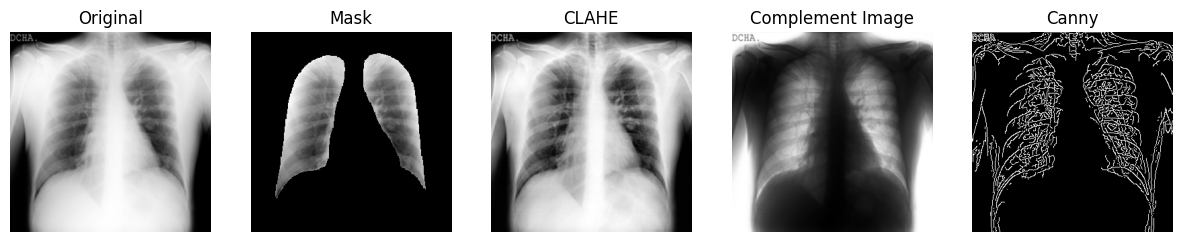

In [ ]:
# Comparison of the pre-processing techniques

# List of dataframes
dataframes = {
    "Original": df,
    "Mask": original_masked_df,
    "CLAHE": original_CLAHE_df,
    "Complement Image": original_complement_df,
    "Canny": original_canny_df
}

# Search for filepaths containing 'COVID-1000' and store them
selected_paths = {}

for name, dataframe in dataframes.items():
    match = dataframe[dataframe["Filepath"].str.contains("COVID-1000", na=False)]
    if not match.empty:
        selected_paths[name] = match.iloc[0]["Filepath"]

# Display images
fig, axes = plt.subplots(1, len(selected_paths), figsize=(15, 5))

for ax, (name, path) in zip(axes, selected_paths.items()):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    ax.imshow(img, cmap="gray")
    ax.set_title(name)
    ax.axis("off")

plt.show()

# Reload original dataset to avoid overwriting df when running this code

original_dataset_dir = Path(r"covid19-radiography-database/COVID-19_Radiography_Dataset")
filepaths = list(original_dataset_dir.glob('*/images/*.*'))
labels = [os.path.basename(os.path.dirname(filepath.parent)) for filepath in filepaths]
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
df = pd.concat([filepaths, labels], axis=1)

In [ ]:
# Comparison between unbalanced and balanced for CNN

# Create the unbalanced custom CNN results
unbalanced_custom_cnn_results = {
    "Metric": ["Test Loss", "Test Accuracy", "Test Precision", "Test Recall", "Test AUC",
               "COVID Precision", "COVID Recall", "Lung Opacity Precision", "Lung Opacity Recall",
               "Normal Precision", "Normal Recall", "Viral Pneumonia Precision", "Viral Pneumonia Recall",
               "Overall Accuracy"],
    "Original (Unbalanced)": [0.6445, 0.8720, 0.8763, 0.8682, 0.9618, 0.87, 0.89, 0.84, 0.81, 0.88, 0.90, 0.96, 0.92, 0.87]
}

# Create the balanced custom CNN results
balanced_custom_cnn_results = {
    "Metric": ["Test Loss", "Test Accuracy", "Test Precision", "Test Recall", "Test AUC",
               "COVID Precision", "COVID Recall", "Lung Opacity Precision", "Lung Opacity Recall",
               "Normal Precision", "Normal Recall", "Viral Pneumonia Precision", "Viral Pneumonia Recall",
               "Overall Accuracy"],
    "Undersampled (Balanced)": [0.5747, 0.8318, 0.8428, 0.8169, 0.9530, 0.86, 0.84, 0.77, 0.78, 0.77, 0.75, 0.93, 0.95, 0.83]
}

# Convert to pandas DataFrames
unbalanced_custom_cnn_df = pd.DataFrame(unbalanced_custom_cnn_results)
balanced_custom_cnn_df = pd.DataFrame(balanced_custom_cnn_results)

# Merge the dataframes on the "Metric" column for vertical comparison
comparison_custom_cnn_df = pd.merge(unbalanced_custom_cnn_df, balanced_custom_cnn_df, on="Metric")

# Display the comparison
comparison_custom_cnn_df

Metric  Original (Unbalanced)  Undersampled (Balanced)
0                   Test Loss                 0.6445                   0.5747
1               Test Accuracy                 0.8720                   0.8318
2              Test Precision                 0.8763                   0.8428
3                 Test Recall                 0.8682                   0.8169
4                    Test AUC                 0.9618                   0.9530
5             COVID Precision                 0.8700                   0.8600
6                COVID Recall                 0.8900                   0.8400
7      Lung Opacity Precision                 0.8400                   0.7700
8         Lung Opacity Recall                 0.8100                   0.7800
9            Normal Precision                 0.8800                   0.7700
10              Normal Recall                 0.9000                   0.7500
11  Viral Pneumonia Precision                 0.9600                   0.9300
12     Viral Pneumonia Recall                 0.9200                   0.9500
13           Overall Accuracy                 0.8700                   0.8300

In [ ]:
# Comparison between unbalanced and balanced for VGG19

# Create a dictionary with the results
data = {
    "Metric": ["Accuracy", "Test Precision", "Test Recall", "Test AUC",
               "COVID Precision", "COVID Recall", "COVID F1-Score",
               "Lung_Opacity Precision", "Lung_Opacity Recall", "Lung_Opacity F1-Score",
               "Normal Precision", "Normal Recall", "Normal F1-Score",
               "Viral Pneumonia Precision", "Viral Pneumonia Recall", "Viral Pneumonia F1-Score"],

    "Original (Unbalanced)": [0.94, 0.918, 0.912, 0.98,
                         0.93, 0.98, 0.95,
                         0.95, 0.86, 0.90,
                         0.92, 0.97, 0.95,
                         0.98, 0.91, 0.94],

    "Undersampled (Balanced)": [0.914, 0.918, 0.912, 0.98,
                             0.91, 0.95, 0.93,
                             0.92, 0.84, 0.88,
                             0.85, 0.91, 0.88,
                             0.98, 0.96, 0.97]
}

# Create the DataFrame
df_vgg_comparison = pd.DataFrame(data)

# Display the DataFrame
df_vgg_comparison

Metric  Original (Unbalanced)  Undersampled (Balanced)
0                    Accuracy                  0.940                    0.914
1              Test Precision                  0.918                    0.918
2                 Test Recall                  0.912                    0.912
3                    Test AUC                  0.980                    0.980
4             COVID Precision                  0.930                    0.910
5                COVID Recall                  0.980                    0.950
6              COVID F1-Score                  0.950                    0.930
7      Lung_Opacity Precision                  0.950                    0.920
8         Lung_Opacity Recall                  0.860                    0.840
9       Lung_Opacity F1-Score                  0.900                    0.880
10           Normal Precision                  0.920                    0.850
11              Normal Recall                  0.970                    0.910
12            Normal F1-Score                  0.950                    0.880
13  Viral Pneumonia Precision                  0.980                    0.980
14     Viral Pneumonia Recall                  0.910                    0.960
15   Viral Pneumonia F1-Score                  0.940                    0.970

In [ ]:
# Comparison between unbalanced and balanced for DenseNet

# Create the unbalanced dataset results
unbalanced_results = {
    "Metric": ["Test Loss", "Test Accuracy", "Test Precision", "Test Recall", "Test AUC",
               "COVID Precision", "COVID Recall", "Lung Opacity Precision", "Lung Opacity Recall",
               "Normal Precision", "Normal Recall", "Viral Pneumonia Precision", "Viral Pneumonia Recall",
               "Overall Accuracy"],
    "Original (Unbalanced)": [0.2966, 0.9312, 0.9324, 0.9289, 0.9843, 0.96, 0.97, 0.92, 0.89, 0.93, 0.94, 0.97, 0.97, 0.93]
}

# Create the balanced dataset results
balanced_results = {
    "Metric": ["Test Loss", "Test Accuracy", "Test Precision", "Test Recall", "Test AUC",
               "COVID Precision", "COVID Recall", "Lung Opacity Precision", "Lung Opacity Recall",
               "Normal Precision", "Normal Recall", "Viral Pneumonia Precision", "Viral Pneumonia Recall",
               "Overall Accuracy"],
    "Undersampled (Balanced)": [0.4097, 0.8810, 0.8863, 0.8764, 0.9753, 0.89, 0.87, 0.84, 0.84, 0.83, 0.84, 0.96, 0.97, 0.88]
}

# Convert to pandas DataFrames
unbalanced_df = pd.DataFrame(unbalanced_results)
balanced_df = pd.DataFrame(balanced_results)

# Merge the dataframes on the "Metric" column for vertical comparison
df_dn_comparison = pd.merge(unbalanced_df, balanced_df, on="Metric")

# Display the comparison
df_dn_comparison

Metric  Original (Unbalanced)  Undersampled (Balanced)
0                   Test Loss                 0.2966                   0.4097
1               Test Accuracy                 0.9312                   0.8810
2              Test Precision                 0.9324                   0.8863
3                 Test Recall                 0.9289                   0.8764
4                    Test AUC                 0.9843                   0.9753
5             COVID Precision                 0.9600                   0.8900
6                COVID Recall                 0.9700                   0.8700
7      Lung Opacity Precision                 0.9200                   0.8400
8         Lung Opacity Recall                 0.8900                   0.8400
9            Normal Precision                 0.9300                   0.8300
10              Normal Recall                 0.9400                   0.8400
11  Viral Pneumonia Precision                 0.9700                   0.9600
12     Viral Pneumonia Recall                 0.9700                   0.9700
13           Overall Accuracy                 0.9300                   0.8800

In [ ]:
def plot_validation_accuracies(history_files_dict, color_dict=None):
    """
    Plots validation accuracy for multiple models, each containing different preprocessing techniques.

    Args:
        history_files_dict (dict): Dictionary where keys are model names (e.g., "VGG19")
                                   and values are dictionaries of preprocessing techniques and their history file paths.
        color_dict (dict, optional): Dictionary where keys are labels and values are specific colors to be used for each line.
                                      If None, default colors will be applied.
    """
    # Default colors for better distinction, if no color_dict is provided
    default_colors = ["b", "g", "r", "orange", "purple", "cyan", "magenta", "chocolate"]

    # Number of models to plot
    num_models = len(history_files_dict)

    # Initialize figure with subplots for each model
    plt.figure(figsize=(6 * num_models, 5))

    # Loop through models and create subplots
    for i, (model_name, history_files) in enumerate(history_files_dict.items()):
        plt.subplot(1, num_models, i + 1)  # Arrange in one row
        for j, (label, file) in enumerate(history_files.items()):
            df = pd.read_csv(file)

            # Choose color for the line
            color = color_dict.get(label, default_colors[j]) if color_dict else default_colors[j]

            # Plot the validation accuracy with the selected color
            plt.plot(df["val_accuracy"], label=label, color=color)

        plt.title(f"{model_name} Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

    # Show all plots
    plt.tight_layout()
    plt.show()

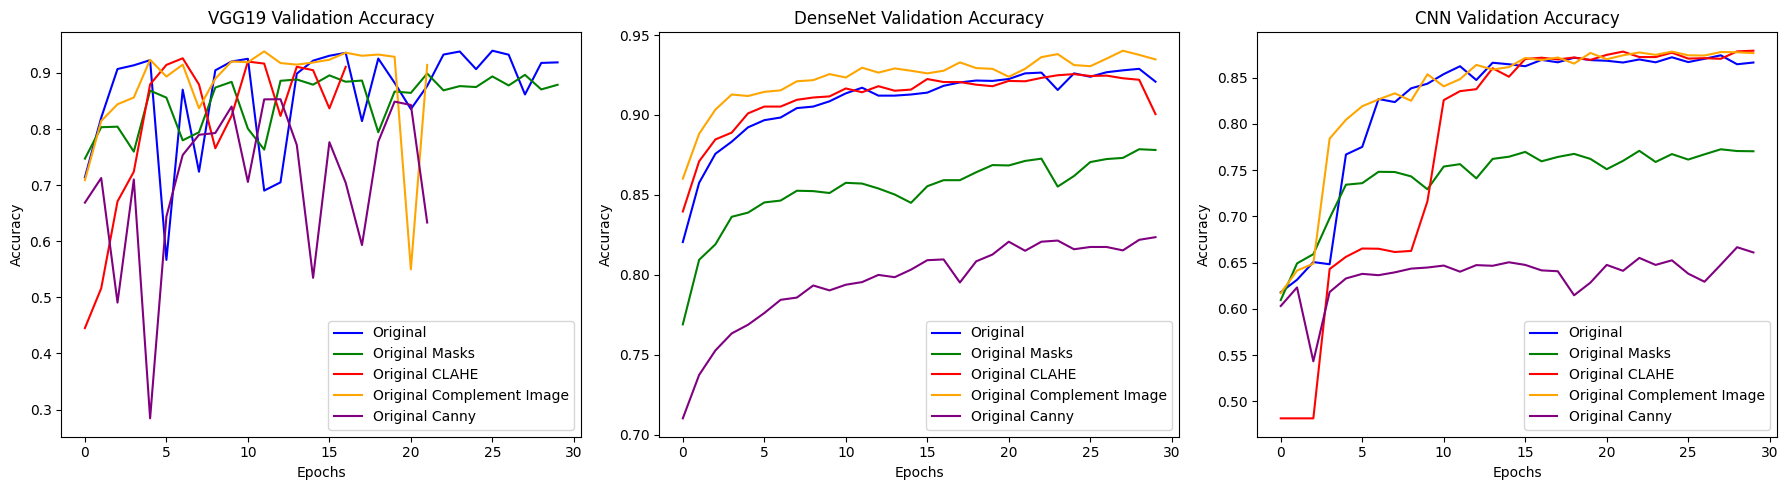

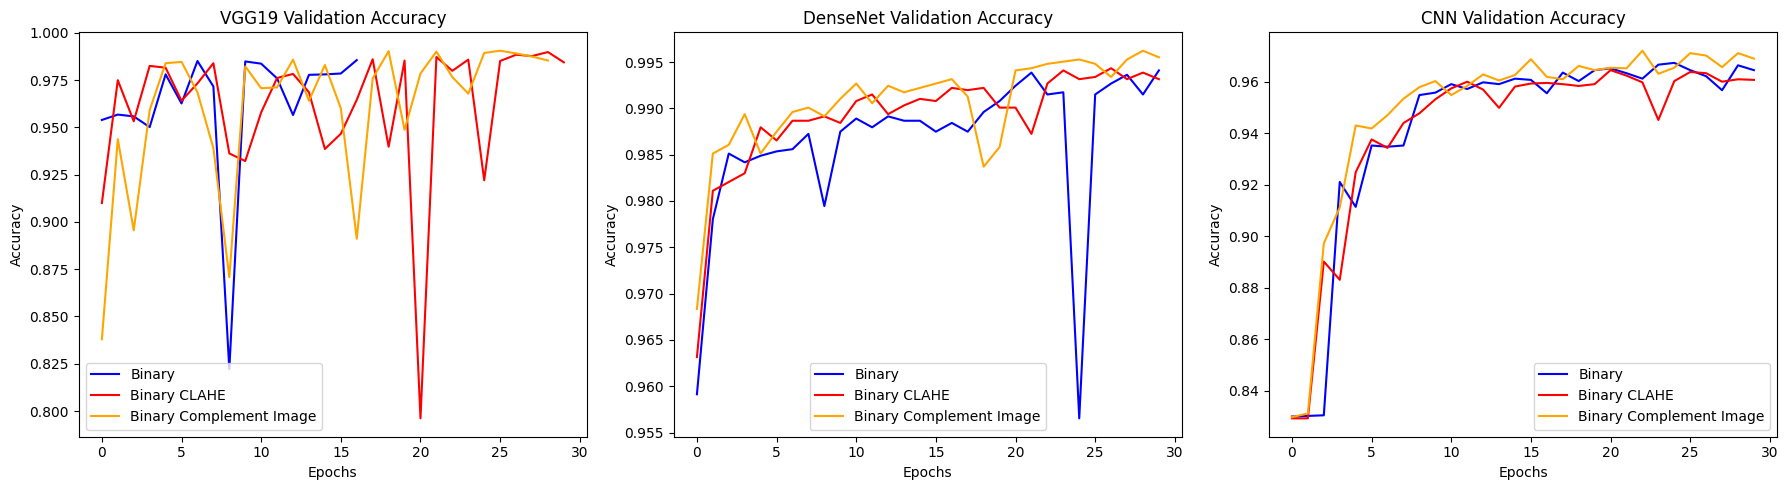

In [ ]:
# Multiclass

history_files_dict_multiclass = {
    "VGG19": {
        "Original": "history_vgg19_original.csv",
        "Original Masks": "history_vgg19_original_masks.csv",
        "Original CLAHE": "history_vgg19_original_CLAHE.csv",
        "Original Complement Image": "history_vgg19_original_compl.csv",
        "Original Canny": "history_vgg19_original_canny.csv",
    },
    "DenseNet": {
        "Original": "history_dn_original.csv",
        "Original Masks": "history_dn_original_masks.csv",
        "Original CLAHE": "history_dn_original_CLAHE.csv",
        "Original Complement Image": "history_dn_original_compl.csv",
        "Original Canny": "history_dn_original_canny.csv",
    },
    "CNN": {
        "Original": "history_cnn_original.csv",
        "Original Masks": "history_cnn_original_masks.csv",
        "Original CLAHE": "history_cnn_original_CLAHE.csv",
        "Original Complement Image": "history_cnn_original_compl.csv",
        "Original Canny": "history_cnn_original_canny.csv",
    }
}

color_dict_multiclass = {
    "Original": "blue",
    "Original Masks": "green",
    "Original CLAHE": "red",
    "Original Complement Image": "orange",
    "Original Canny": "purple"
}

plot_validation_accuracies(history_files_dict_multiclass, color_dict=color_dict_multiclass)

# Binary

history_files_dict_binary = {
    "VGG19": {
        "Binary": "history_vgg19_binary.csv",
        "Binary CLAHE": "history_vgg19_binary_CLAHE.csv",
        "Binary Complement Image": "history_vgg19_binary_compl.csv"
    },
    "DenseNet": {
        "Binary": "history_dn_binary.csv",
        "Binary CLAHE": "history_dn_binary_CLAHE.csv",
        "Binary Complement Image": "history_dn_binary_compl.csv"
    },
    "CNN": {
        "Binary": "history_cnn_binary.csv",
        "Binary CLAHE": "history_cnn_binary_CLAHE.csv",
        "Binary Complement Image": "history_cnn_binary_compl.csv"
    }
}

color_dict_binary = {
    "Binary": "blue",
    "Binary CLAHE": "red",
    "Binary Complement Image": "orange"
}

plot_validation_accuracies(history_files_dict_binary, color_dict=color_dict_binary)

In [ ]:
# Table of the results

# Define MultiIndex columns (stacked headers)
columns = pd.MultiIndex.from_tuples(
    [("Preprocessing", "")] +
    [(model, metric) for model in ["VGG19", "DenseNet", "CNN"]
     for metric in ["Loss", "Accuracy", "Precision", "Recall", "AUC"]]
)

# Define the table data with the Preprocessing column
data = [
    ["Original", 825.440, 0.935, 0.935, 0.934, 0.977, 0.297, 0.931, 0.932, 0.929, 0.984, 0.645, 0.872, 0.876, 0.868, 0.962],
    ["Original + Masks", 0.408, 0.896, 0.897, 0.894, 0.976, 0.518, 0.879, 0.880, 0.878, 0.967, 1.124, 0.781, 0.787, 0.773, 0.918],
    ["Original + CLAHE", 0.219, 0.923, 0.926, 0.921, 0.990, 0.339, 0.925, 0.926, 0.924, 0.981, 0.639, 0.864, 0.866, 0.861, 0.960],
    ["Original + Complement", 0.220, 0.940, 0.941, 0.938, 0.989, 0.326, 0.924, 0.925, 0.923, 0.982, 0.459, 0.880, 0.884, 0.878, 0.970],
    ["Original + Canny", 0.574, 0.850, 0.854, 0.847, 0.960, 0.723, 0.826, 0.829, 0.822, 0.949, 0.825, 0.666, 0.794, 0.586, 0.890],
    ["Binary", 0.039, 0.989, 0.989, 0.989, 0.998, 0.017, 0.996, 0.995, 0.995, 0.999, 0.227, 0.958, 0.959, 0.957, 0.985],
    ["Binary + CLAHE", 0.102, 0.988, 0.989, 0.988, 0.997, 0.025, 0.993, 0.993, 0.994, 0.999, 0.150, 0.964, 0.965, 0.963, 0.989],
    ["Binary + Complement", 0.032, 0.992, 0.992, 0.992, 0.998, 0.013, 0.996, 0.996, 0.996, 0.999, 0.153, 0.969, 0.969, 0.970, 0.989]
]

# Create DataFrame with MultiIndex columns
results_df = pd.DataFrame(data, columns=columns)

# Save to CSV
results_df.to_csv("formatted_results.csv", index=False)

# Print the table
results_df

Preprocessing    VGG19                                  DenseNet  \
                             Loss Accuracy Precision Recall    AUC     Loss   
0               Original  825.440    0.935     0.935  0.934  0.977    0.297   
1       Original + Masks    0.408    0.896     0.897  0.894  0.976    0.518   
2       Original + CLAHE    0.219    0.923     0.926  0.921  0.990    0.339   
3  Original + Complement    0.220    0.940     0.941  0.938  0.989    0.326   
4       Original + Canny    0.574    0.850     0.854  0.847  0.960    0.723   
5                 Binary    0.039    0.989     0.989  0.989  0.998    0.017   
6         Binary + CLAHE    0.102    0.988     0.989  0.988  0.997    0.025   
7    Binary + Complement    0.032    0.992     0.992  0.992  0.998    0.013   

                                      CNN                                   
  Accuracy Precision Recall    AUC   Loss Accuracy Precision Recall    AUC  
0    0.931     0.932  0.929  0.984  0.645    0.872     0.876  0.868  0.962  
1    0.879     0.880  0.878  0.967  1.124    0.781     0.787  0.773  0.918  
2    0.925     0.926  0.924  0.981  0.639    0.864     0.866  0.861  0.960  
3    0.924     0.925  0.923  0.982  0.459    0.880     0.884  0.878  0.970  
4    0.826     0.829  0.822  0.949  0.825    0.666     0.794  0.586  0.890  
5    0.996     0.995  0.995  0.999  0.227    0.958     0.959  0.957  0.985  
6    0.993     0.993  0.994  0.999  0.150    0.964     0.965  0.963  0.989  
7    0.996     0.996  0.996  0.999  0.153    0.969     0.969  0.970  0.989

# Grad-CAM

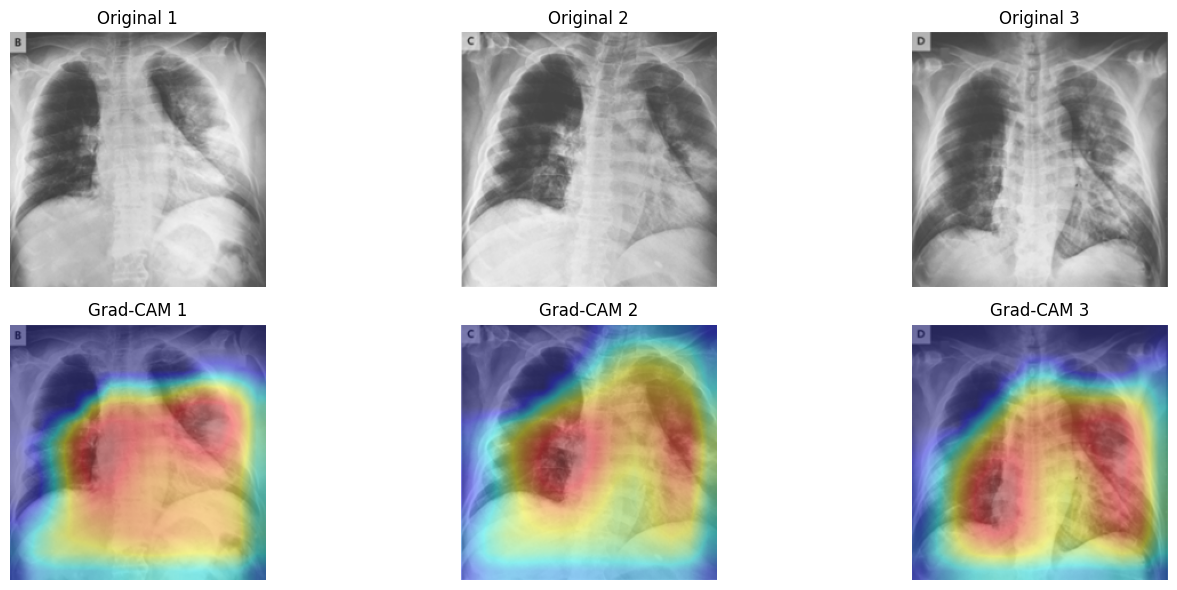

In [ ]:
# Grad-CAM for binary classification on the original dataset with VGG19

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_grad_cam_vgg(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image.

    Args:
        model: Trained TensorFlow/Keras model.
        img_array: Preprocessed image array (batch size of 1).
        last_conv_layer_name: Name of the last convolutional layer.
        pred_index: Index of the predicted class (None to use top prediction).

    Returns:
        heatmap: Grad-CAM heatmap.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Index of the top predicted class
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU and normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def overlay_grad_cam_vgg(image, heatmap, alpha=0.4):
    """
    Overlay Grad-CAM heatmap on original image.

    Args:
        image: Original image in BGR format.
        heatmap: Grad-CAM heatmap.
        alpha: Transparency factor for heatmap overlay.

    Returns:
        Blended image with Grad-CAM overlay.
    """
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0)

    return blended

def plot_grad_cam_overlays_vgg(image_paths, model, last_conv_layer="block5_conv4"):
    """
    Plot the original images and their corresponding Grad-CAM overlays.

    Args:
        image_paths: List of image file paths.
        model: Trained Keras model.
        last_conv_layer: Name of the last convolutional layer to use for Grad-CAM.
    """
    num_images = len(image_paths)
    plt.figure(figsize=(15, 6))  # Adjusted figure size

    for i, image_path in enumerate(image_paths):
        # Load and preprocess image
        image = cv2.imread(image_path)
        image_resized = cv2.resize(image, (224, 224))  # Resize to model input size
        img_array = np.expand_dims(image_resized / 255.0, axis=0)  # Normalize

        # Generate Grad-CAM heatmap
        heatmap = get_grad_cam_vgg(model, img_array, last_conv_layer_name=last_conv_layer)

        # Overlay heatmap on the original image
        overlay_image = overlay_grad_cam_vgg(image_resized, heatmap)

        # Plot original image (first row)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
        plt.title(f"Covid {i+1}")
        plt.axis("off")

        # Plot Grad-CAM overlay (second row)
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Grad-CAM {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
image_paths = [
    "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-5.png",
    "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-8.png",
    "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-11.png"
]

# Load the trained model (modify the path accordingly)
model_path = "/content/vgg_binary.keras"  # Replace with actual path
model_vgg19_binary = tf.keras.models.load_model(model_path)

# Call the function to display original images and Grad-CAM overlays
plot_grad_cam_overlays_vgg(image_paths, model_vgg19_binary, last_conv_layer="block5_conv4")